In [1]:
import os
import csv
import numpy as np
import pandas as pd
import math
from math import sqrt
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.gridspec import GridSpec
import lightgbm as lgb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from pdpbox import pdp, get_dataset,info_plots
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

from sklearn.inspection import permutation_importance
import shap

# 1 Data import and pre-pocsssing

In [2]:
dtypes = [
    ("QD-source", "category"), ("Core", "category"), ("Shell", "category"),
    ("QD-diameter-nm", "float32"), ("Surface-ligand", "category"), ("Surface-charge", "category"),
    ("Surface-modification", "category"), ("Cell-anatomical-type", "category"), ("Cell-source-species", "category"),
    ("Cell-origin", "category"), ("Assay-type", "category"), ("Delivery-type", "category"),
    ("Exposure-time-hrs", "float32"), ("IC50-mgL-1", "float32")
]
raw_data = pd.read_excel("data_IC50.xlsx",
    names=[d[0] for d in dtypes],
    dtype=dict(dtypes)
)

raw_data['IC50-log-mgL-1'] = np.log10(raw_data['IC50-mgL-1'].values)
del raw_data['IC50-mgL-1']

raw_data

QD-source  Core     Shell  QD-diameter-nm       Surface-ligand  \
0      In-house  CdSe  No-shell            3.37           Alkylthiol   
1      In-house  CdSe  No-shell            3.37           Alkylthiol   
2      In-house  CdSe  No-shell            4.98           Alkylthiol   
3      In-house  CdSe  No-shell            9.48           Alkylthiol   
4    Commercial  CdSe       ZnS            9.00  Amphiphilic-polymer   
..          ...   ...       ...             ...                  ...   
509    In-house  CdTe       CdS            3.90           Alkylthiol   
510    In-house  CdSe       ZnS            5.50           Alkylthiol   
511    In-house  CdSe       ZnS            5.50           Alkylthiol   
512    In-house  CdSe       CdS            4.30  Hydrophilic-Polymer   
513    In-house  CdSe       CdS            4.30  Hydrophilic-Polymer   

    Surface-charge Surface-modification Cell-anatomical-type  \
0         Negative           Unmodified           Epithelial   
1          Neutral           Unmodified           Epithelial   
2          Neutral           Unmodified           Epithelial   
3          Neutral           Unmodified           Epithelial   
4         Negative           Unmodified           Epithelial   
..             ...                  ...                  ...   
509       Negative          Nucleicacid           Epithelial   
510       Negative           Unmodified           Epithelial   
511       Negative           Unmodified           Fibroblast   
512       Negative           Unmodified           Epithelial   
513       Negative           Unmodified           Epithelial   

    Cell-source-species Cell-origin Assay-type Delivery-type  \
0                Human      Primary        WST       Passive   
1                Human      Primary        WST       Passive   
2                Human      Primary        WST       Passive   
3                Human      Primary        WST       Passive   
4                Human    Cell-line        MTT       Passive   
..                  ...         ...        ...           ...   
509              Human    Cell-line        MTT        Active   
510              Human    Cell-line        MTS       Passive   
511              Human      Primary        MTS       Passive   
512             Hamster   Cell-line        MTT       Passive   
513             Hamster   Cell-line        MTT       Passive   

     Exposure-time-hrs  IC50-log-mgL-1  
0                 22.0        1.653213  
1                 22.0        0.397940  
2                 22.0       -0.154902  
3                 22.0        0.477121  
4                 24.0        1.276378  
..                 ...             ...  
509               24.0        2.392680  
510               48.0        1.954242  
511               48.0        1.954242  
512               24.0        1.301030  
513               48.0        1.096910  

[514 rows x 14 columns]

In [3]:
filt_dtypes = list(filter(lambda x: not (x[0] in ["IC50-log-mgL-1"]), dtypes))
filt_dtypes

[('QD-source', 'category'),
 ('Core', 'category'),
 ('Shell', 'category'),
 ('QD-diameter-nm', 'float32'),
 ('Surface-ligand', 'category'),
 ('Surface-charge', 'category'),
 ('Surface-modification', 'category'),
 ('Cell-anatomical-type', 'category'),
 ('Cell-source-species', 'category'),
 ('Cell-origin', 'category'),
 ('Assay-type', 'category'),
 ('Delivery-type', 'category'),
 ('Exposure-time-hrs', 'float32'),
 ('IC50-mgL-1', 'float32')]

In [4]:
# 保证结果的复现，保存生成的随机数
#random_index = random.sample(range(0, len(data)), len(data))
#np.save('random_index.npy',random_index)
random_index = np.load('random_index.npy')
random_index[0:5]
data = raw_data.loc[random_index,:]
data.head(5)

QD-source  Core     Shell  QD-diameter-nm       Surface-ligand  \
242    In-house  CdSe      ZnSe             4.0               Polyol   
315    In-house  CdTe  No-shell             3.3            Aminoacid   
101  Commercial  CdTe       CdS             5.0  Hydrophilic-Polymer   
277    In-house  CdTe      ZnTe             4.8           Alkylthiol   
467    In-house  CdSe       ZnS             5.0           Alkylthiol   

    Surface-charge Surface-modification Cell-anatomical-type  \
242     Zwitterion              Peptide          Endothelial   
315     Zwitterion              Peptide           Epithelial   
101       Negative           Unmodified           Epithelial   
277       Negative                Toxin           Fibroblast   
467       Negative           Unmodified             Myoblast   

    Cell-source-species Cell-origin Assay-type Delivery-type  \
242              Human    Cell-line        MTT        Active   
315              Human    Cell-line        MTT        Active   
101              Human    Cell-line        MTT       Passive   
277               Mouse   Cell-line        MTT        Active   
467              Rabbit     Primary        MTT       Passive   

     Exposure-time-hrs  IC50-log-mgL-1  
242               24.0        2.301030  
315               12.0        3.475473  
101               12.0        1.568202  
277               24.0        2.301030  
467               24.0        0.954243

In [5]:
X_raw = data.drop(['IC50-log-mgL-1'], axis=1)
y = data['IC50-log-mgL-1']
X_raw.head(5)

QD-source  Core     Shell  QD-diameter-nm       Surface-ligand  \
242    In-house  CdSe      ZnSe             4.0               Polyol   
315    In-house  CdTe  No-shell             3.3            Aminoacid   
101  Commercial  CdTe       CdS             5.0  Hydrophilic-Polymer   
277    In-house  CdTe      ZnTe             4.8           Alkylthiol   
467    In-house  CdSe       ZnS             5.0           Alkylthiol   

    Surface-charge Surface-modification Cell-anatomical-type  \
242     Zwitterion              Peptide          Endothelial   
315     Zwitterion              Peptide           Epithelial   
101       Negative           Unmodified           Epithelial   
277       Negative                Toxin           Fibroblast   
467       Negative           Unmodified             Myoblast   

    Cell-source-species Cell-origin Assay-type Delivery-type  \
242              Human    Cell-line        MTT        Active   
315              Human    Cell-line        MTT        Active   
101              Human    Cell-line        MTT       Passive   
277               Mouse   Cell-line        MTT        Active   
467              Rabbit     Primary        MTT       Passive   

     Exposure-time-hrs  
242               24.0  
315               12.0  
101               12.0  
277               24.0  
467               24.0

In [6]:
X = pd.get_dummies(X_raw)
X.to_excel('IC50_onehot.xlsx')
X.head(5)

QD-diameter-nm  Exposure-time-hrs  QD-source_Commercial  \
242             4.0               24.0                     0   
315             3.3               12.0                     0   
101             5.0               12.0                     1   
277             4.8               24.0                     0   
467             5.0               24.0                     0   

     QD-source_In-house  Core_CdHgTe  Core_CdS  Core_CdSe  Core_CdSeTe  \
242                   1            0         0          1            0   
315                   1            0         0          0            0   
101                   0            0         0          0            0   
277                   1            0         0          0            0   
467                   1            0         0          1            0   

     Core_CdTe  Core_CdZnS  ...  Assay-type_Others  Assay-type_Proliferation  \
242          0           0  ...                  0                         0   
315          1           0  ...                  0                         0   
101          1           0  ...                  0                         0   
277          1           0  ...                  0                         0   
467          0           0  ...                  0                         0   

     Assay-type_RT-CES  Assay-type_Resazurin  Assay-type_SRB  Assay-type_WST  \
242                  0                     0               0               0   
315                  0                     0               0               0   
101                  0                     0               0               0   
277                  0                     0               0               0   
467                  0                     0               0               0   

     Assay-type_live/dead-staining  Assay-type_methylene-blue  \
242                              0                          0   
315                              0                          0   
101                              0                          0   
277                              0                          0   
467                              0                          0   

     Delivery-type_Active  Delivery-type_Passive  
242                     1                      0  
315                     1                      0  
101                     0                      1  
277                     1                      0  
467                     0                      1  

[5 rows x 100 columns]

In [7]:
y

242    2.301030
315    3.475473
101    1.568202
277    2.301030
467    0.954243
         ...   
10     1.276378
253    0.591065
439    1.838424
465    1.322219
212    0.343549
Name: IC50-log-mgL-1, Length: 514, dtype: float32

In [8]:
fature_name = X_raw.columns
fature_name

Index(['QD-source', 'Core', 'Shell', 'QD-diameter-nm', 'Surface-ligand',
       'Surface-charge', 'Surface-modification', 'Cell-anatomical-type',
       'Cell-source-species', 'Cell-origin', 'Assay-type', 'Delivery-type',
       'Exposure-time-hrs'],
      dtype='object')

In [9]:
feature_plot_name = ['QD source', 'Core', 'Shell', 'QD diameter (nm)', 'Surface ligand',
       'Surface charge', 'Surface modification', 'Cell anatomical type',
       'Cell source species', 'Cell origin', 'Assay type', 'Delivery type',
       'Exposure time (hours)']
feature_plot_name

['QD source',
 'Core',
 'Shell',
 'QD diameter (nm)',
 'Surface ligand',
 'Surface charge',
 'Surface modification',
 'Cell anatomical type',
 'Cell source species',
 'Cell origin',
 'Assay type',
 'Delivery type',
 'Exposure time (hours)']

# 2 LightGBM

## 2.1 GridSearchCV

In [10]:
parameter = {
    
   # 确定树的大小及复杂度
   #  "max_depth": np.arange(2,15,1),
   #  "num_leaves": np.arange(2,25,1),
    
   # 防止树过拟合
   # "min_child_samples": np.arange(1,10,1), 
   # "min_child_weight": np.arange(0,0.002,0.0001),
    
    "learning_rate": np.arange(0,0.2,0.005),
}

model_gs = lgb.LGBMRegressor(n_estimators=1000,n_jobs=-1,max_depth=10,num_leaves=11,min_child_samples=8,min_child_weight=0,learning_rate=0.145)
grid_search = GridSearchCV(model_gs, param_grid = parameter, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X, y, categorical_feature=range(2,len(X.columns)))

print('best score: ', grid_search.best_score_)
print('best_params:', grid_search.best_params_)
LGBM_Gs_best = grid_search.best_estimator_

best score:  0.7401305944925538
best_params: {'learning_rate': 0.145}


## 2.2 LightGBM modeling

RMSE_train: 0.21 
R2_train: 0.98 
RMSE_test: 0.66 
R2_test: 0.72 


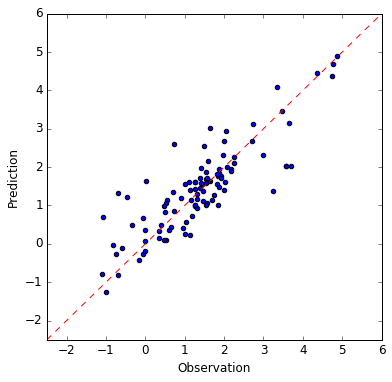

In [11]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model = lgb.LGBMRegressor(n_estimators=1000,n_jobs=-1,max_depth=8,num_leaves=17,min_child_samples=7,min_child_weight=0,learning_rate=0.04)
model.fit(X_train, y_train, categorical_feature=range(2,len(X.columns)))
y_pred = model.predict(X_test) 
y_train_pred = model.predict(X_train) 

print('RMSE_train: %.2f ' %sqrt(mean_squared_error(y_train, y_train_pred)))  # 训练集MSE
print('R2_train: %.2f ' %r2_score(y_train, y_train_pred))  # 训练集R方
print('RMSE_test: %.2f ' %sqrt(mean_squared_error(y_test, y_pred)))  # 测试集MSE
print('R2_test: %.2f ' %r2_score(y_test, y_pred))  # 测试集R方

figure = plt.figure(figsize=(6,6))  # 设定画布大小
plt.style.use('classic')
plt.xlim(-2.5, 6)
plt.ylim(-2.5, 6)
plt.plot([-2.5,6],[-2.5,6],color="r",linestyle='--')
plt.scatter(y_test, y_pred)
plt.xlabel('Observation')
plt.ylabel('Prediction')

plt.plot()
figure.savefig("./Result_fig_IC50_LightGBM/Predcitons_observations_one-hot.jpg",dpi=600,bbox_inches='tight')

# 3 Interpretability

In [12]:
Model = model
select_X = X
sorted_features = np.load('sorted_features.npy')

In [13]:
select_X

QD-diameter-nm  Exposure-time-hrs  QD-source_Commercial  \
242             4.0               24.0                     0   
315             3.3               12.0                     0   
101             5.0               12.0                     1   
277             4.8               24.0                     0   
467             5.0               24.0                     0   
..              ...                ...                   ...   
10              9.0               24.0                     1   
253             6.2               20.0                     1   
439             3.2               48.0                     0   
465             3.1               24.0                     0   
212             4.3               48.0                     1   

     QD-source_In-house  Core_CdHgTe  Core_CdS  Core_CdSe  Core_CdSeTe  \
242                   1            0         0          1            0   
315                   1            0         0          0            0   
101                   0            0         0          0            0   
277                   1            0         0          0            0   
467                   1            0         0          1            0   
..                  ...          ...       ...        ...          ...   
10                    0            0         0          1            0   
253                   0            0         0          0            0   
439                   1            0         0          1            0   
465                   1            0         1          0            0   
212                   0            0         0          0            1   

     Core_CdTe  Core_CdZnS  ...  Assay-type_Others  Assay-type_Proliferation  \
242          0           0  ...                  0                         0   
315          1           0  ...                  0                         0   
101          1           0  ...                  0                         0   
277          1           0  ...                  0                         0   
467          0           0  ...                  0                         0   
..         ...         ...  ...                ...                       ...   
10           0           0  ...                  0                         0   
253          1           0  ...                  0                         1   
439          0           0  ...                  0                         0   
465          0           0  ...                  0                         0   
212          0           0  ...                  0                         0   

     Assay-type_RT-CES  Assay-type_Resazurin  Assay-type_SRB  Assay-type_WST  \
242                  0                     0               0               0   
315                  0                     0               0               0   
101                  0                     0               0               0   
277                  0                     0               0               0   
467                  0                     0               0               0   
..                 ...                   ...             ...             ...   
10                   0                     0               0               0   
253                  0                     0               0               0   
439                  0                     0               0               0   
465                  0                     0               0               0   
212                  0                     0               0               0   

     Assay-type_live/dead-staining  Assay-type_methylene-blue  \
242                              0                          0   
315                              0                          0   
101                              0                          0   
277                              0                          0   
467                              0                          0   
..                             ... 

## 3.1  PDP Global feature contributions

### 3.1.1 Numeric feature

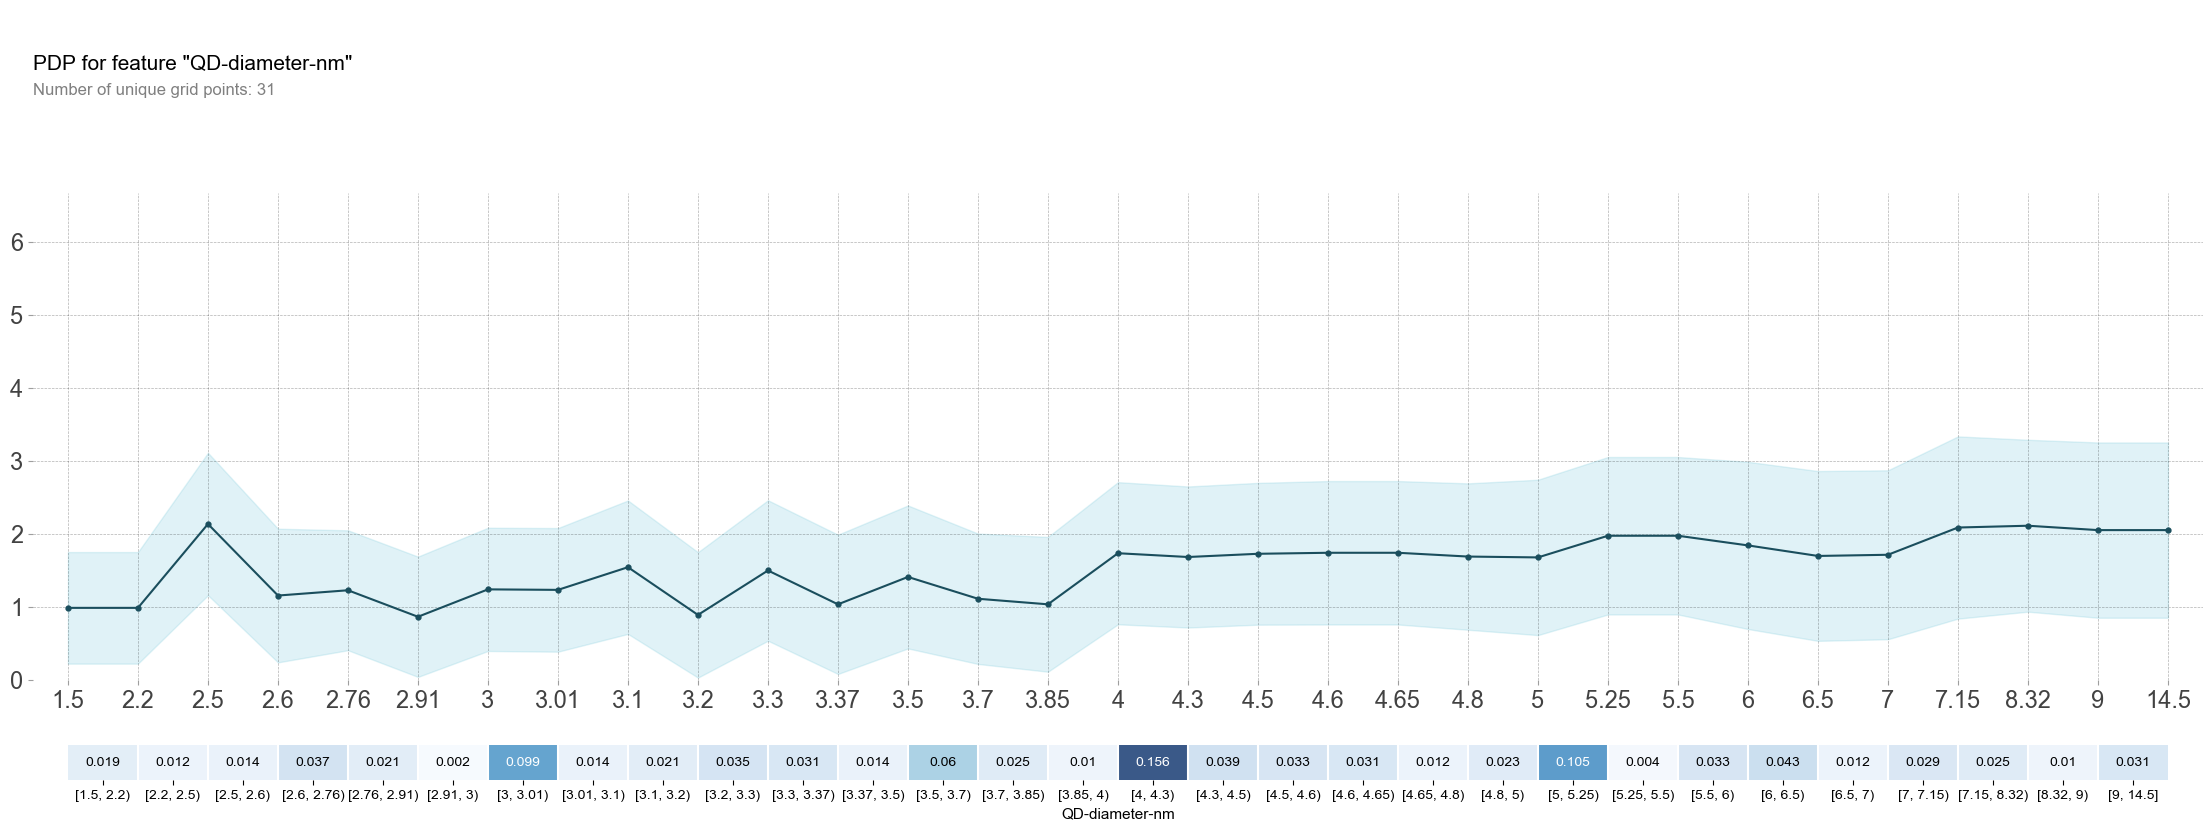

In [14]:
plt.style.use('default')
feature = "QD-diameter-nm"
pdp_NP_none_M = pdp.pdp_isolate(model=Model,
                        dataset=select_X,
                        model_features=select_X.columns,
                        feature=feature,
                        n_jobs=-1, num_grid_points=50)
ax = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=False, center=False,
                    plot_pts_dist=True, 
                    x_quantile=True,
                    feature_name=feature,
                    figsize=(28, 10))
ax[0].savefig("./Result_fig_IC50_LightGBM/Global_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

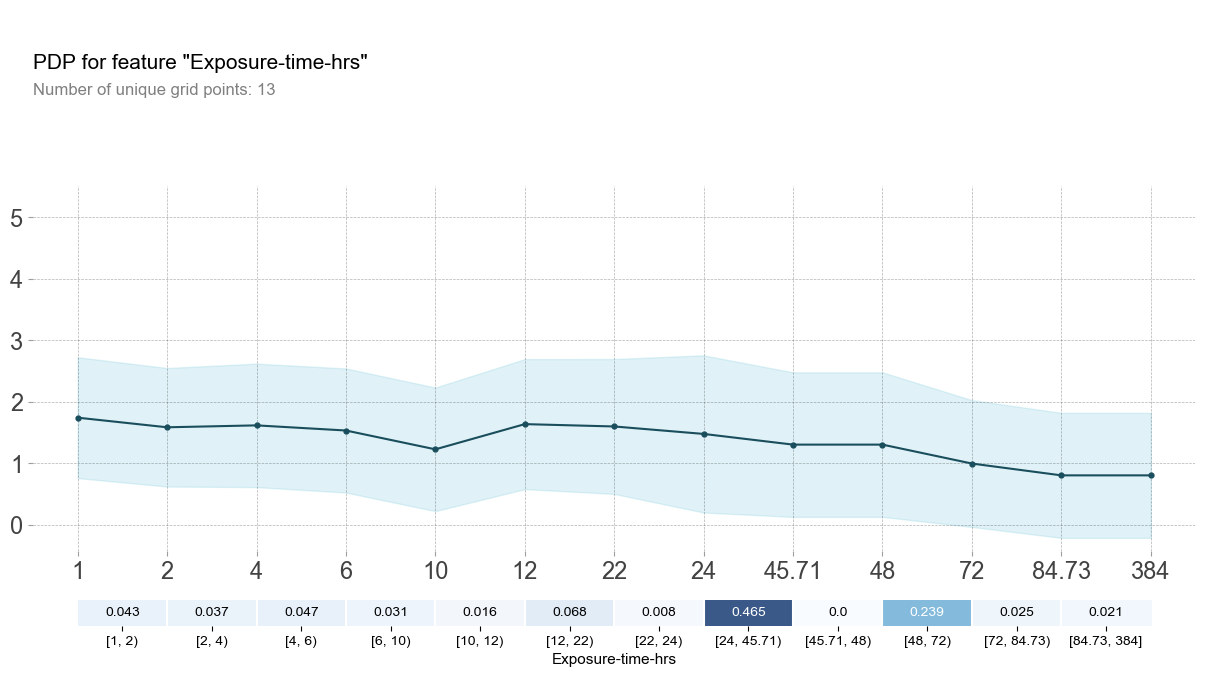

In [15]:
feature = "Exposure-time-hrs"
pdp_NP_none_M = pdp.pdp_isolate(model=Model,
                        dataset=select_X,
                        model_features=select_X.columns,
                        feature=feature,
                        n_jobs=-1, num_grid_points=50)
ax = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=False, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=True,
                    feature_name=feature,
                    figsize=(15, 8))
ax[0].savefig("./Result_fig_IC50_LightGBM/Global_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

### 3.1.2 One-hot encoding feature

In [16]:
OneHot_feature = ['QD-source','Core','Shell','Surface-ligand','Surface-charge','Surface-modification',
                    'Cell-anatomical-type','Cell-source-species','Cell-origin','Assay-type','Delivery-type']
OneHot_feature_num = [2,6,9,13,4,11,18,13,2,18,2]

#重要性排序：['Surface-ligand','Cell-anatomical-type','Surface-modification','Core','Shell','Assay-type',
#             'Surface-charge','Cell-source-species','QD-source','Cell-origin','Delivery-type']

# [3,6,5,1,2,9,4,7,0,8,10]

In [17]:
y_prediction = Model.predict(select_X) 

In [18]:
X_y_PDP = X_raw.copy()
X_y_PDP["IC50-log-mgL-1"] = y_prediction
X_y_PDP

QD-source    Core     Shell  QD-diameter-nm       Surface-ligand  \
242    In-house    CdSe      ZnSe             4.0               Polyol   
315    In-house    CdTe  No-shell             3.3            Aminoacid   
101  Commercial    CdTe       CdS             5.0  Hydrophilic-Polymer   
277    In-house    CdTe      ZnTe             4.8           Alkylthiol   
467    In-house    CdSe       ZnS             5.0           Alkylthiol   
..          ...     ...       ...             ...                  ...   
10   Commercial    CdSe       ZnS             9.0  Amphiphilic-polymer   
253  Commercial    CdTe  No-shell             6.2  Amphiphilic-polymer   
439    In-house    CdSe  No-shell             3.2               Polyol   
465    In-house     CdS  No-shell             3.1    Other-Hydrophilic   
212  Commercial  CdSeTe       ZnS             4.3    Other-Hydrophobic   

    Surface-charge Surface-modification Cell-anatomical-type  \
242     Zwitterion              Peptide          Endothelial   
315     Zwitterion              Peptide           Epithelial   
101       Negative           Unmodified           Epithelial   
277       Negative                Toxin           Fibroblast   
467       Negative           Unmodified             Myoblast   
..             ...                  ...                  ...   
10        Negative           Unmodified           Fibroblast   
253       Positive            Aminoacid             Monocyte   
439     Zwitterion                 Drug           Epithelial   
465        Neutral              Protein           Epithelial   
212        Neutral           Unmodified  Monocyte-Macrophage   

    Cell-source-species Cell-origin     Assay-type Delivery-type  \
242              Human    Cell-line            MTT        Active   
315              Human    Cell-line            MTT        Active   
101              Human    Cell-line            MTT       Passive   
277               Mouse   Cell-line            MTT        Active   
467              Rabbit     Primary            MTT       Passive   
..                  ...         ...            ...           ...   
10                  Cow     Primary            MTT       Passive   
253              Human    Cell-line  Proliferation        Active   
439              Human    Cell-line            MTT        Active   
465              Human    Cell-line            MTT        Active   
212               Mouse   Cell-line            MTT       Passive   

     Exposure-time-hrs  IC50-log-mgL-1  
242               24.0        2.378352  
315               12.0        3.463782  
101               12.0        1.635474  
277               24.0        2.303840  
467               24.0        1.335877  
..                 ...             ...  
10                24.0        1.332888  
253               20.0        0.404661  
439               48.0        1.893515  
465               24.0        1.291779  
212               48.0        0.331611  

[514 rows x 14 columns]

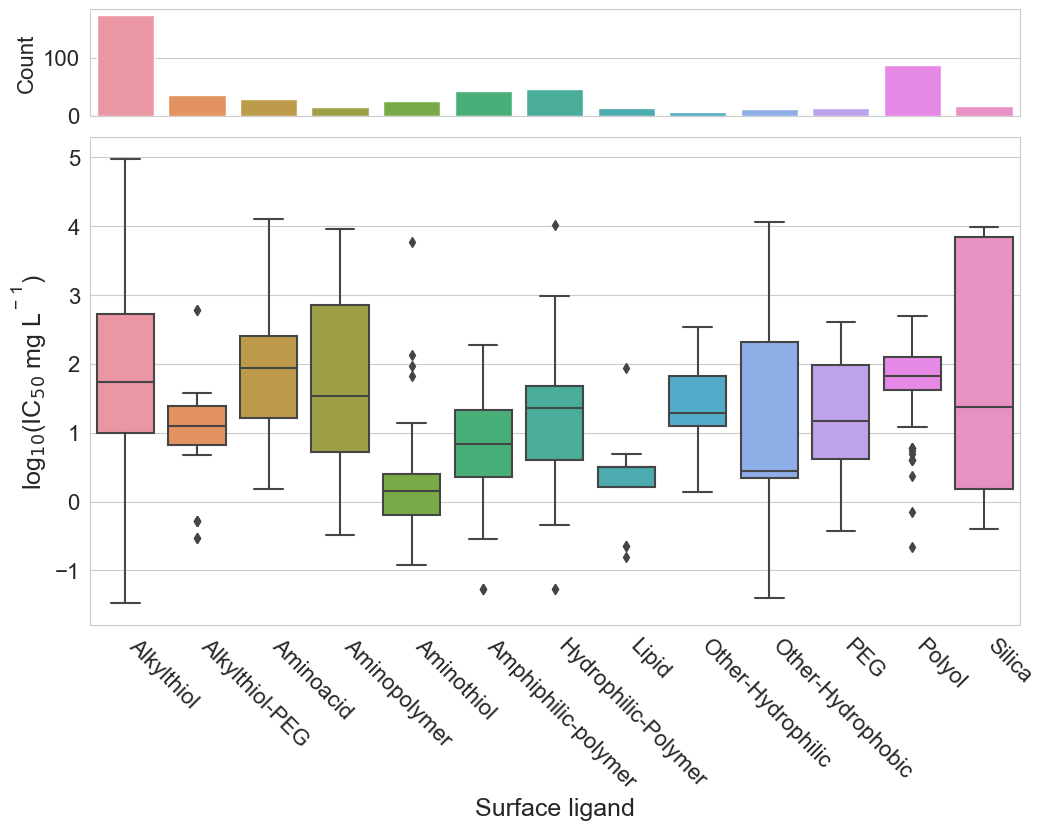

In [19]:
fig = plt.figure(figsize=(12,8))
gs = GridSpec(5, 1)
sns.set_style('whitegrid') # white, dark, whitegrid, darkgrid, ticks
plt.rcParams['font.size'] ='16'
ax1=plt.subplot(gs[0,:])
ax = sns.countplot(x="Surface-ligand", data=X_y_PDP)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.xticks([])
plt.xlabel('')
plt.ylabel('Count')


ax1=plt.subplot(gs[1:,:])
plt.rcParams['font.size'] ='16'
g = sns.boxplot(x="Surface-ligand", y="IC50-log-mgL-1",data=X_y_PDP)
sns.despine(top=False, right=False, left=False, bottom=False)
plt.xticks(rotation=-45,ha ='left')
g.set_xlabel("Surface ligand",fontsize=18)
plt.ylabel('log'+'${_1}$'+'${_0}$'+'(IC'+'${_5}$'+'${_0}$'+' mg L'+'$\mathregular{^-}$'+'$\mathregular{^1}$)',fontsize=18)

fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_test.jpg",dpi=600,bbox_inches='tight') 

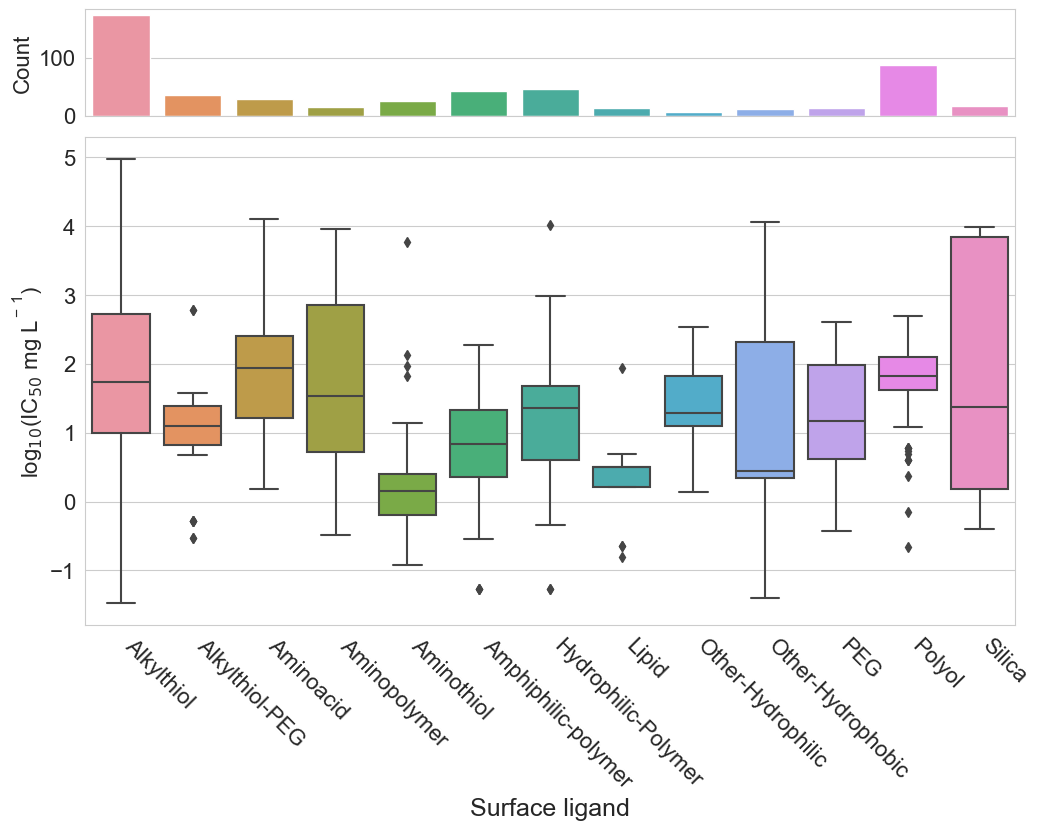

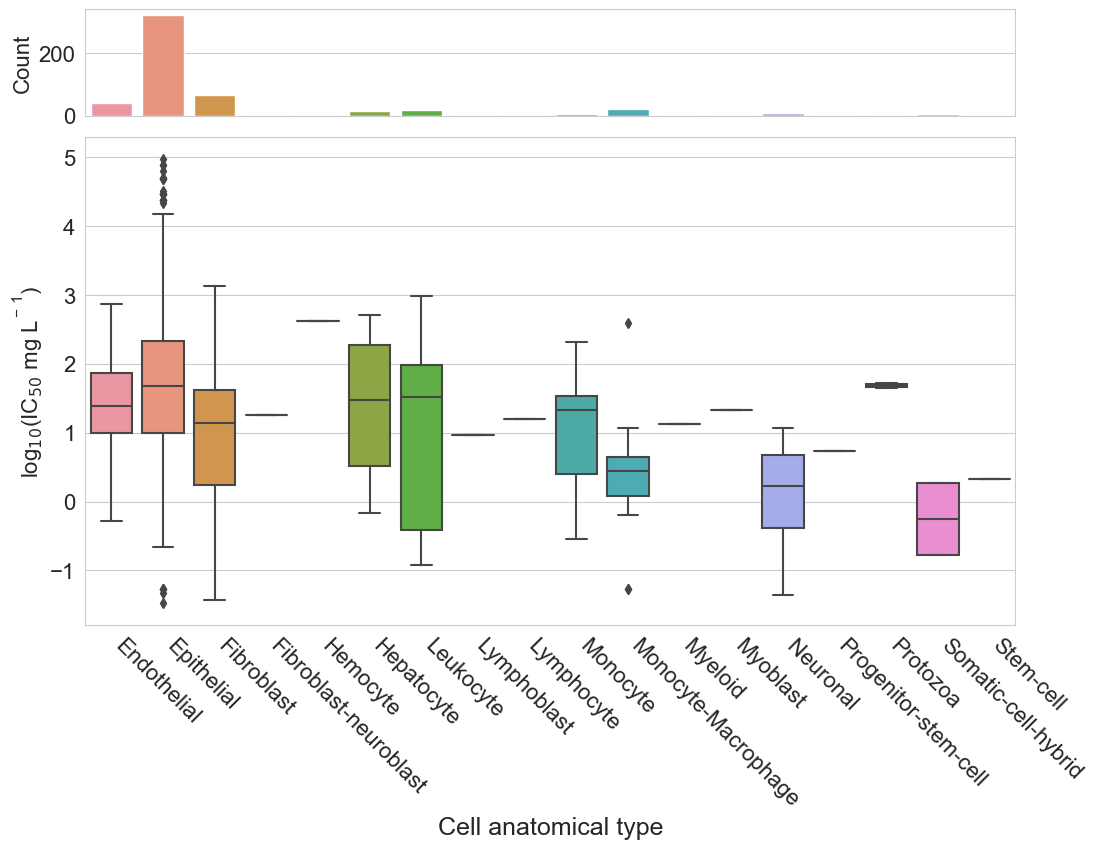

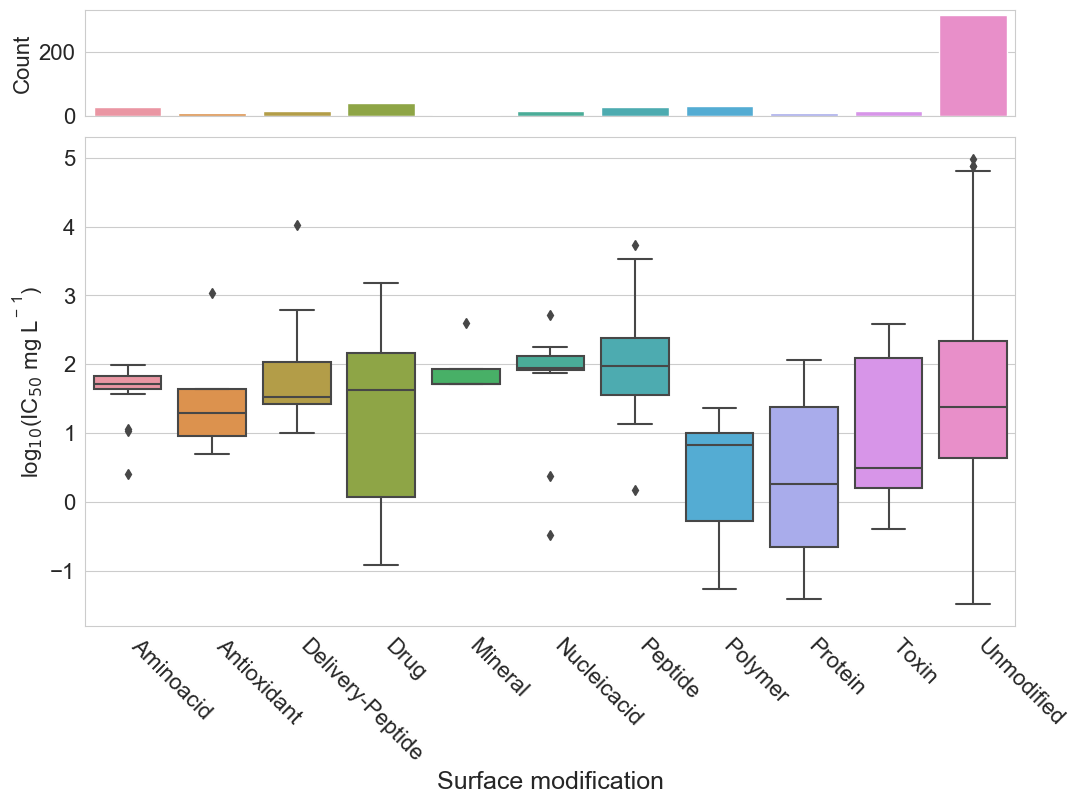

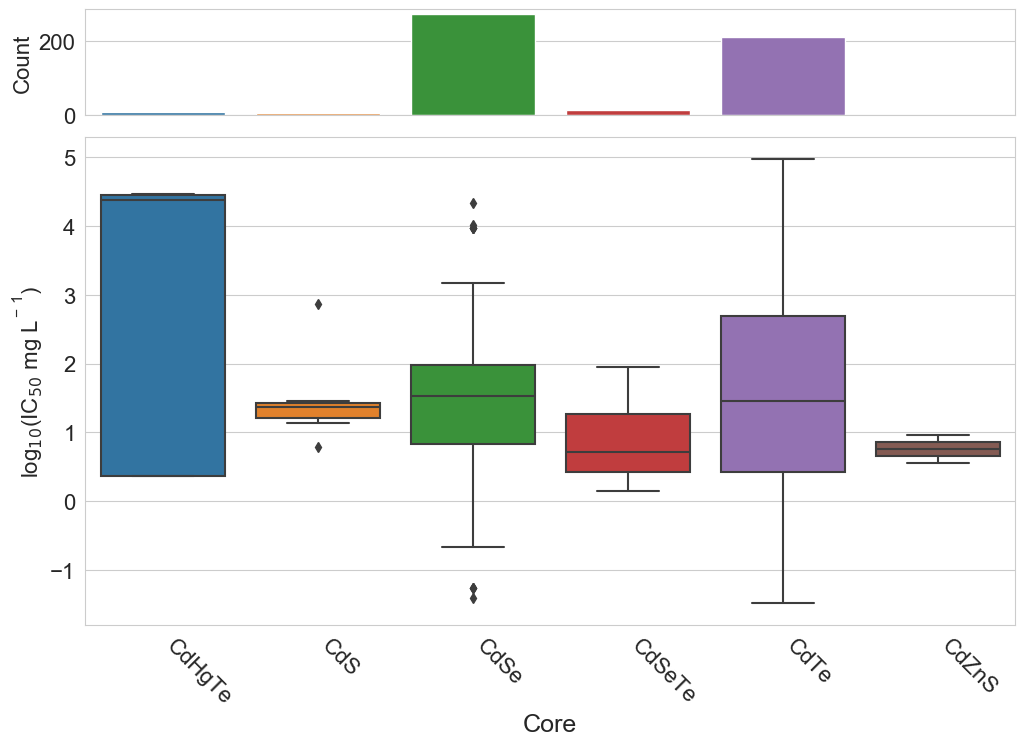

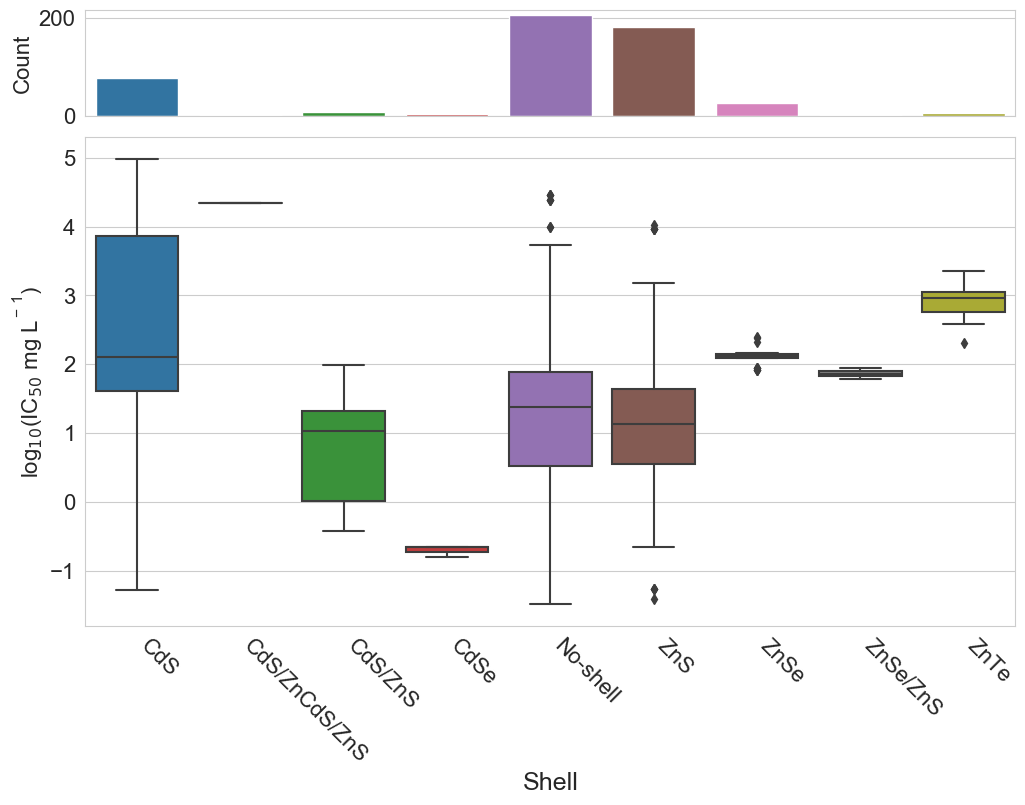

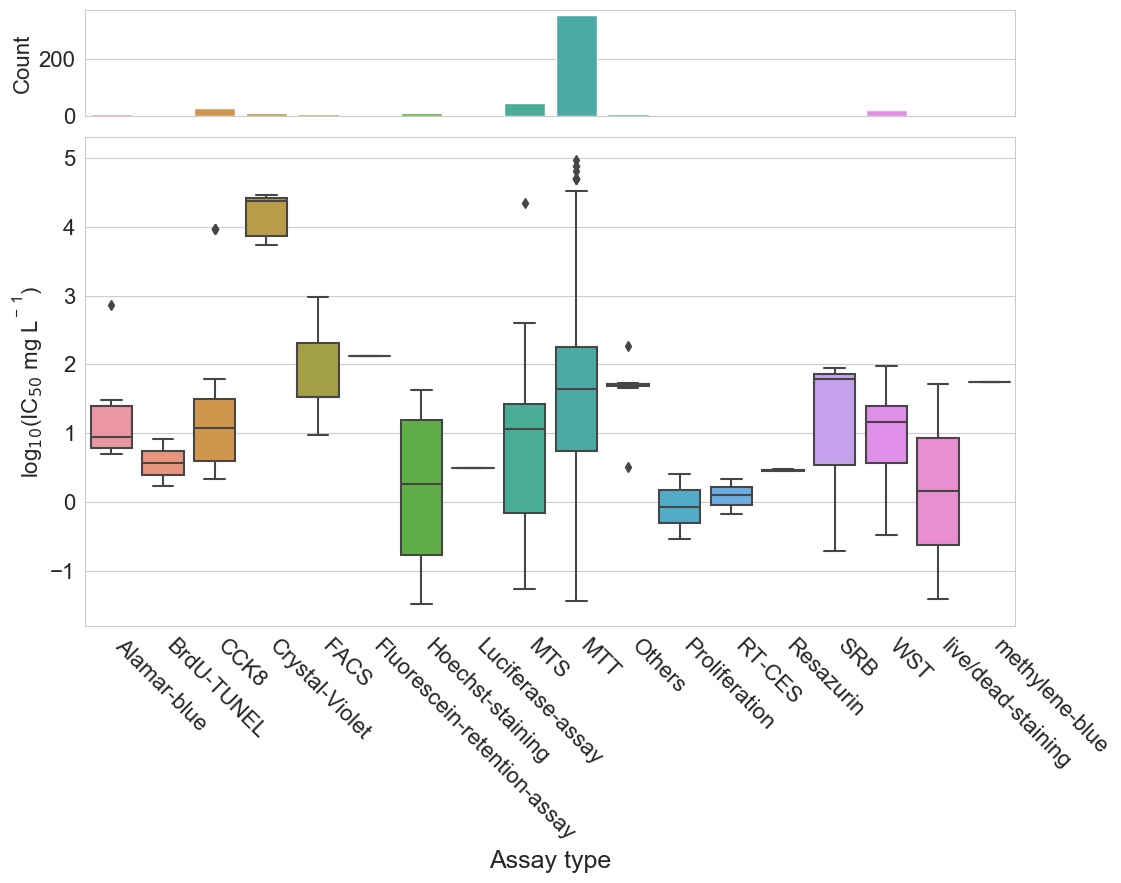

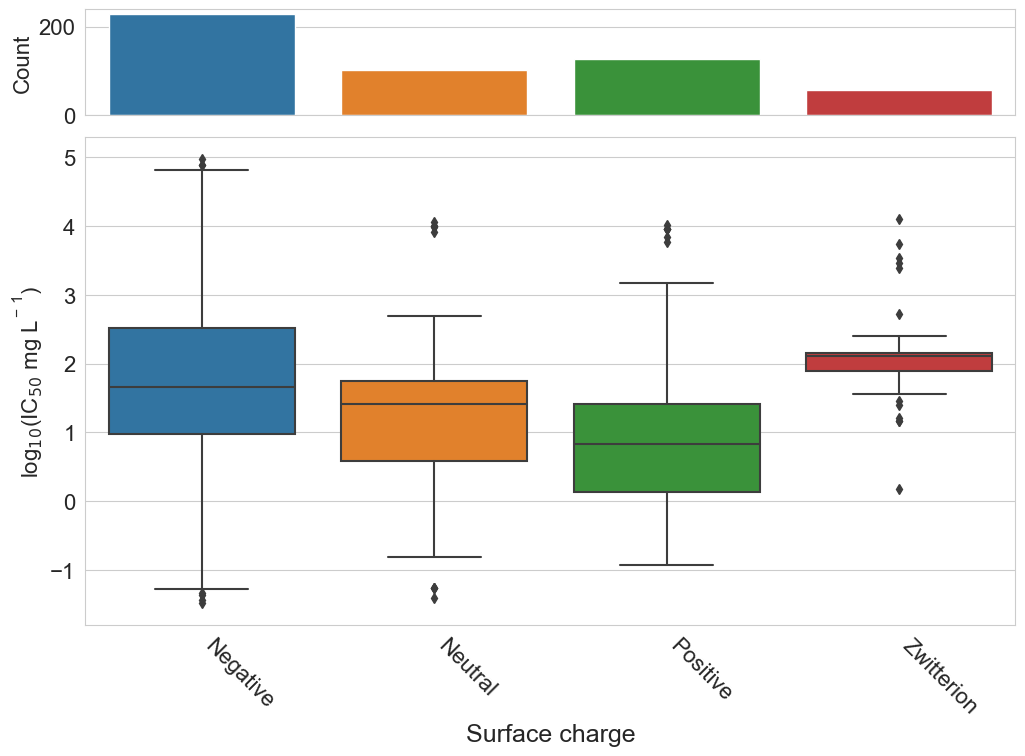

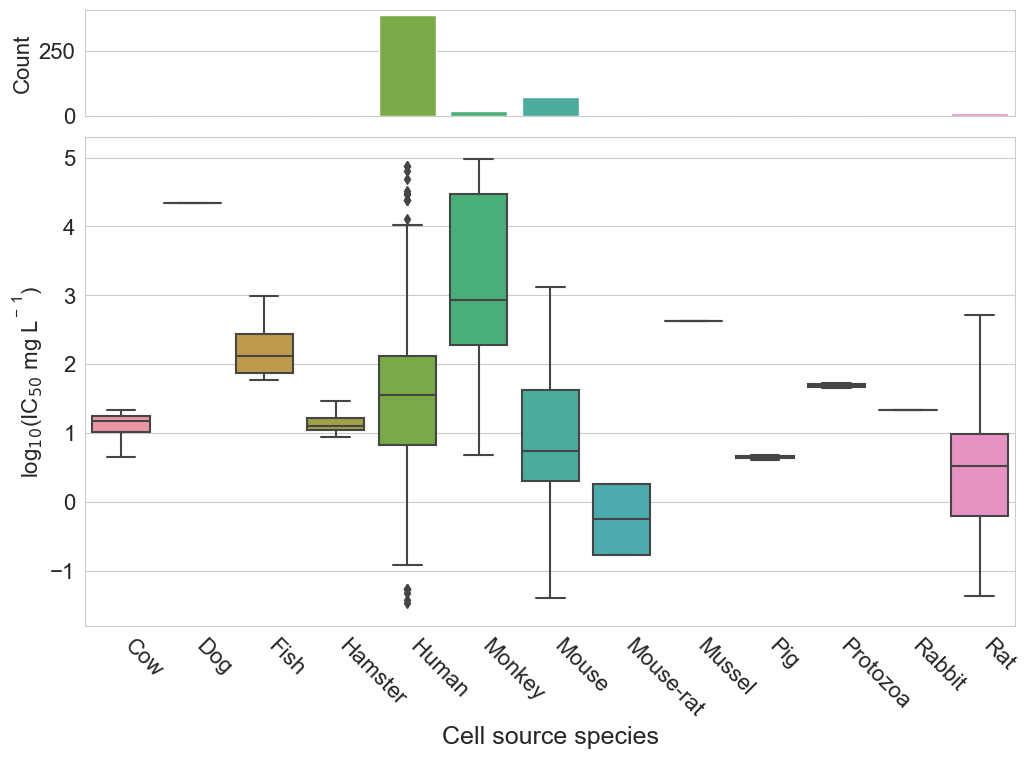

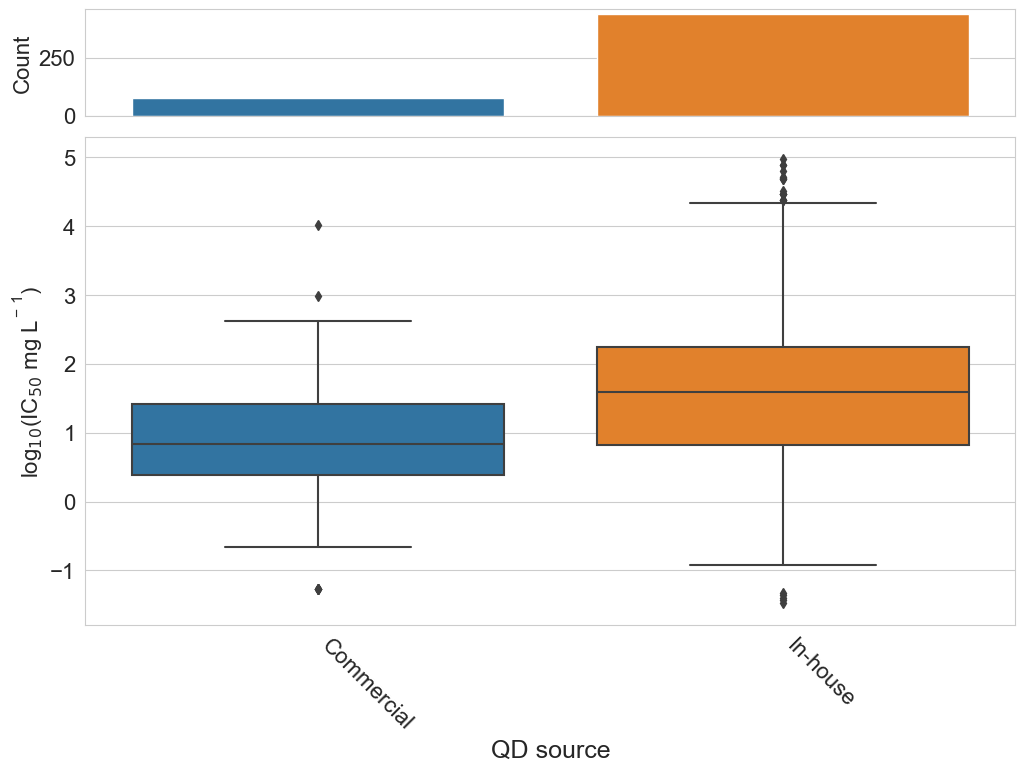

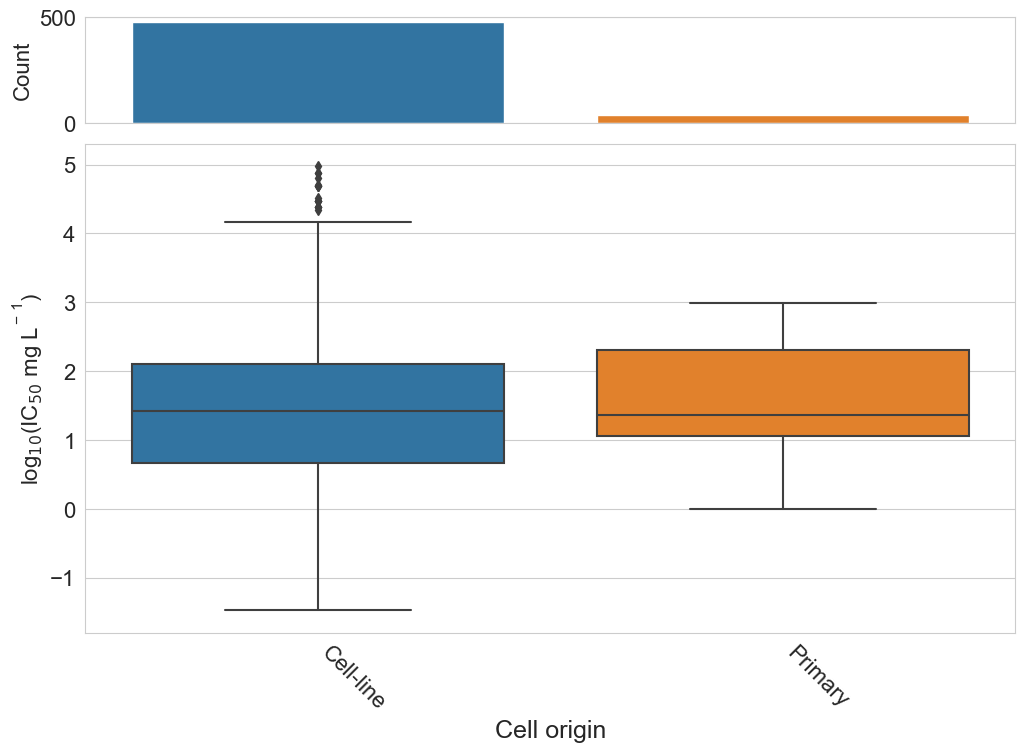

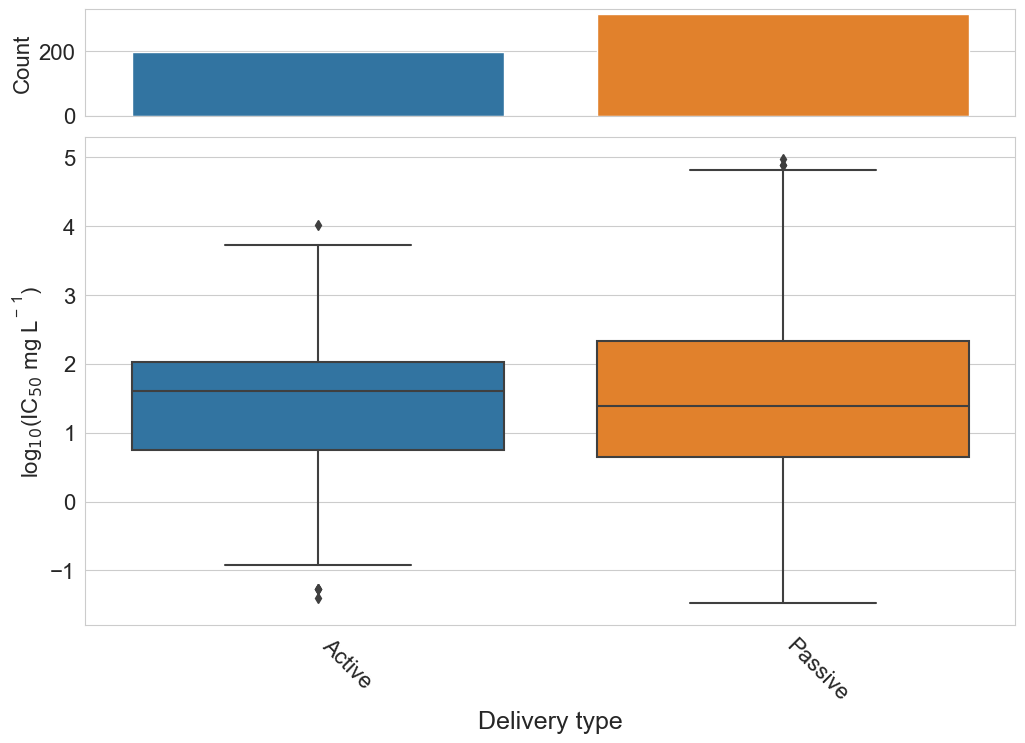

In [20]:
for i in [3,6,5,1,2,9,4,7,0,8,10]:
    fig = plt.figure(figsize=(12,8))
    plt.rcParams['font.size'] ='16'
    gs = GridSpec(5, 1)
    sns.set_style('whitegrid') # white, dark, whitegrid, darkgrid, ticks

    ax1=plt.subplot(gs[0,:])
    ax = sns.countplot(x=OneHot_feature[i], data=X_y_PDP)
    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('Count')
    
    ax1=plt.subplot(gs[1:,:])
    plt.rcParams['font.size'] ='16'
    g = sns.boxplot(x=OneHot_feature[i], y="IC50-log-mgL-1",data=X_y_PDP)
    plt.ylabel('log'+'${_1}$'+'${_0}$'+'(IC'+'${_5}$'+'${_0}$'+' mg L'+'$\mathregular{^-}$'+'$\mathregular{^1}$)')
    sns.despine(top=False, right=False, left=False, bottom=False)
    plt.xticks(rotation=-45,ha ='left')
    feature_this_plot = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
    g.set_xlabel(feature_this_plot,fontsize=18)
    
    fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_%s.jpg"%OneHot_feature[i],dpi=600,bbox_inches='tight') 

X_y = select_X.copy()
X_y["IC50-log-mgL-1"] = y_train

i=8
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]
feature_category

for i in [3,5,1,2,4,7]:
    strat_ind=sum(OneHot_feature_num[0:i])+2
    feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]
    feature_category
    
    fig, axes, summary_df = info_plots.actual_plot(
        model=Model, X=select_X, feature=feature_category.tolist(), predict_kwds={},feature_name=OneHot_feature[i],
        plot_params={'xticks_rotation': -45},figsize=(15, 10))
    
    len_feature_name = len(OneHot_feature[i])
    plot_feature_category = feature_category.tolist()
    for item in range(len(plot_feature_category )):
        plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]
    
    axes['bar_ax'].set_xticklabels(plot_feature_category,ha ='left')
    
    fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_%s.jpg"%OneHot_feature[i],dpi=600,bbox_inches='tight') 

for i in [0,8,10]:
    strat_ind=sum(OneHot_feature_num[0:i])+2
    feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]
    feature_category
    fig, axes, summary_df = info_plots.actual_plot(
        model=Model, X=select_X, feature=feature_category.tolist(), predict_kwds={},feature_name=OneHot_feature[i])
    
    len_feature_name = len(OneHot_feature[i])
    plot_feature_category = feature_category.tolist()
    for item in range(len(plot_feature_category )):
        plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]
    
    axes['bar_ax'].set_xticklabels(plot_feature_category,)
    
    fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_%s.jpg"%OneHot_feature[i],dpi=600,bbox_inches='tight') 

for i in [6,9]:
    strat_ind=sum(OneHot_feature_num[0:i])+2
    feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]
    feature_category
    fig, axes, summary_df = info_plots.actual_plot(
        model=Model, X=select_X, feature=feature_category.tolist(), predict_kwds={},feature_name=OneHot_feature[i],
        plot_params={'xticks_rotation': -45},figsize=(24, 10))
    
    len_feature_name = len(OneHot_feature[i])
    plot_feature_category = feature_category.tolist()
    for item in range(len(plot_feature_category )):
        plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]
    
    axes['bar_ax'].set_xticklabels(plot_feature_category,ha ='left')

    fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_%s.jpg"%OneHot_feature[i],dpi=600,bbox_inches='tight') 

### 3.1.4 pdp for feature combination

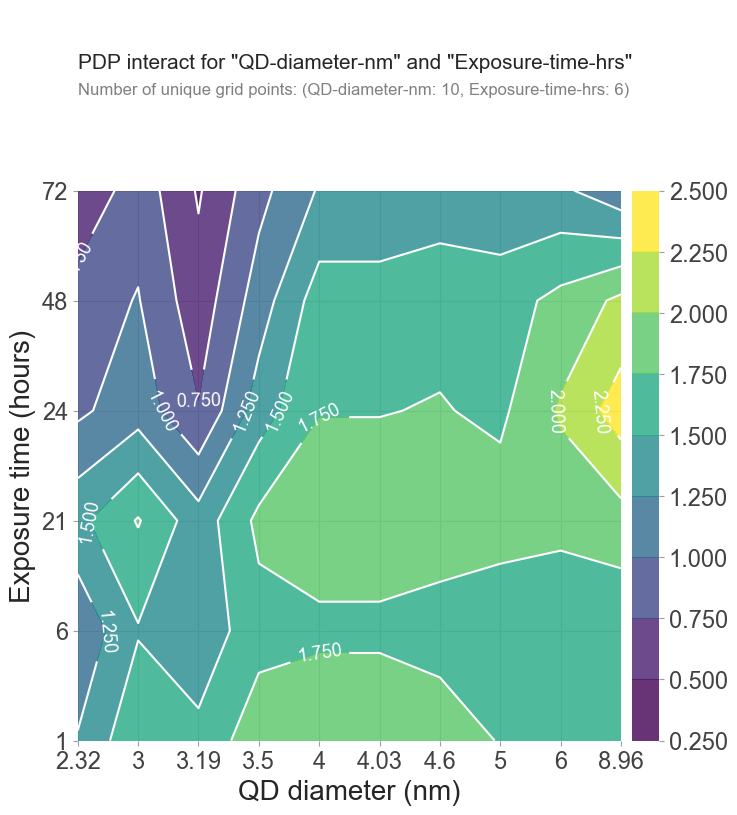

In [21]:
# 两个连续变量

feature1 = "QD-diameter-nm"
feature2 = "Exposure-time-hrs" 

feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == feature1))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == feature2))]

inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature1,feature2],percentile_ranges=[(3,97),(3,97)])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [feature1, feature2], x_quantile=True, plot_type='contour', plot_pdp=False)

axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)

fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(feature1,feature2),dpi=600,bbox_inches='tight') 

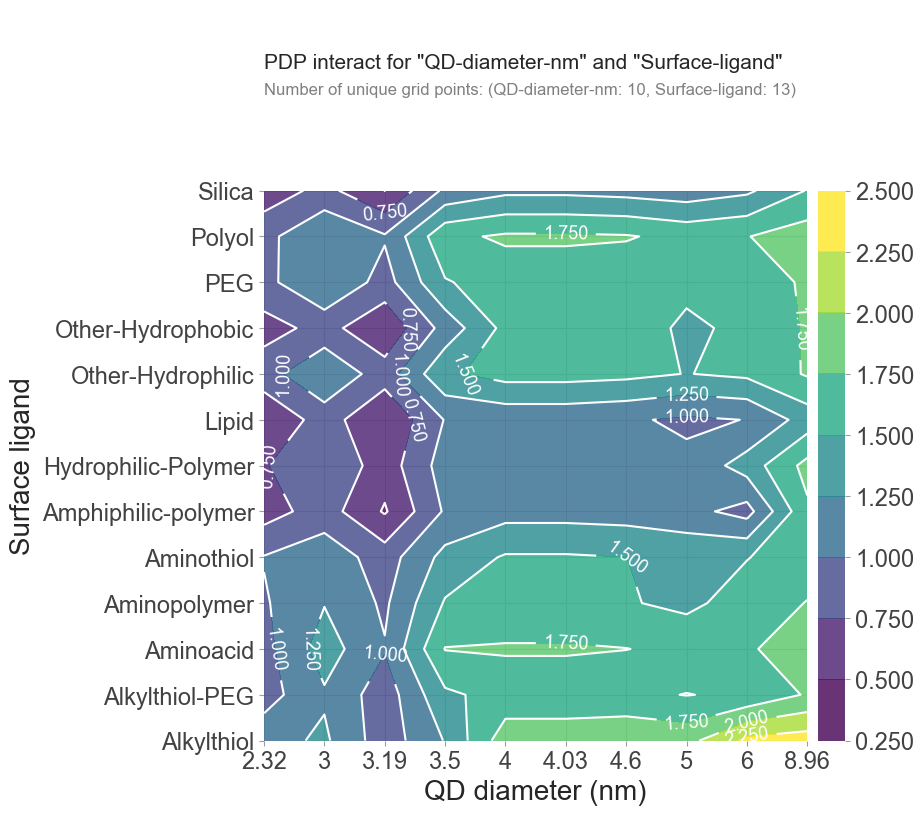

In [22]:
# 一个连续变量，一个分类变量

# OneHot_feature = ['QD-source','Core','Shell','Surface-ligand','Surface-charge','Surface-modification',
#                    'Cell-anatomical-type','Cell-source-species','Cell-origin','Assay-type','Delivery-type']
# OneHot_feature_num = [2,6,9,13,4,11,18,13,2,18,2]

#重要性排序：['Surface-ligand','Cell-anatomical-type','Surface-modification','Core','Shell','Assay-type',
#             'Surface-charge','Cell-source-species','QD-source','Cell-origin','Delivery-type']

# [3,6,5,1,2,9,4,7,0,8,10]

# Numeric feature: "Exposure-time-hrs" "QD-diameter-nm"


i=3
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

feature1 = "QD-diameter-nm"

feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == feature1))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]

inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature1, feature_category.tolist()],percentile_ranges=[(3,97),(0,100)])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [feature1, OneHot_feature[i]], x_quantile=True,plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(feature1,OneHot_feature[i]),dpi=600,bbox_inches='tight') 

In [23]:
OneHot_feature

['QD-source',
 'Core',
 'Shell',
 'Surface-ligand',
 'Surface-charge',
 'Surface-modification',
 'Cell-anatomical-type',
 'Cell-source-species',
 'Cell-origin',
 'Assay-type',
 'Delivery-type']

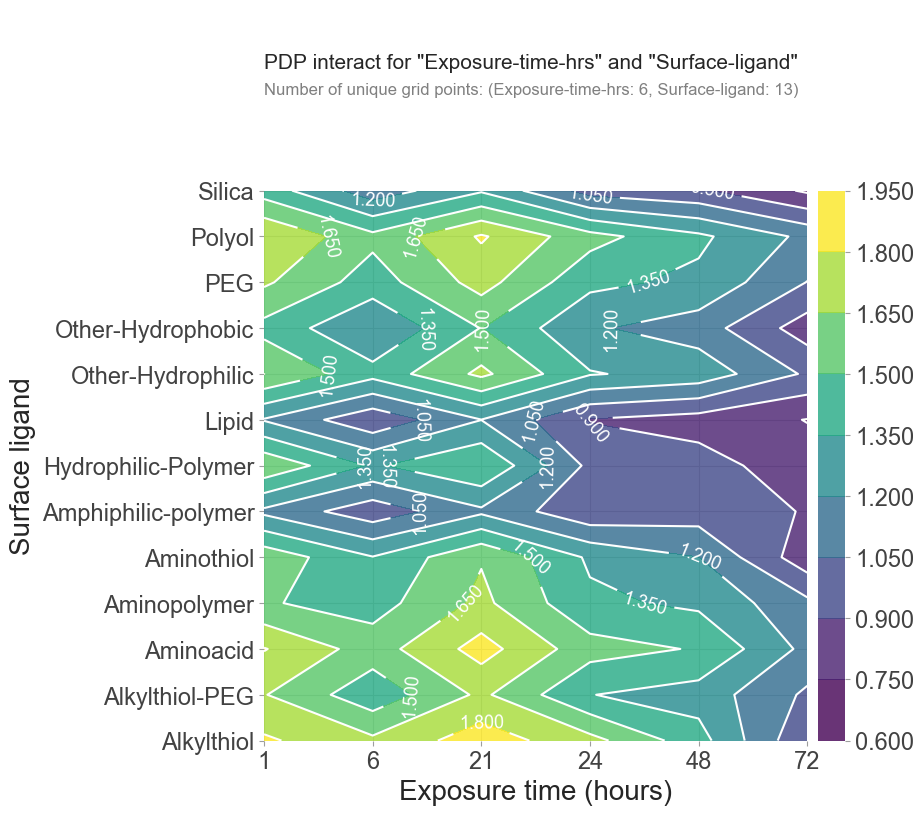

In [24]:
# 一个连续变量，一个分类变量

i=3
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

feature1 = "Exposure-time-hrs"
feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == feature1))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature1, feature_category.tolist()],percentile_ranges=[(3,97),(0,100)])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [feature1, OneHot_feature[i]], x_quantile=True, plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(feature1,OneHot_feature[i]),dpi=600,bbox_inches='tight') 

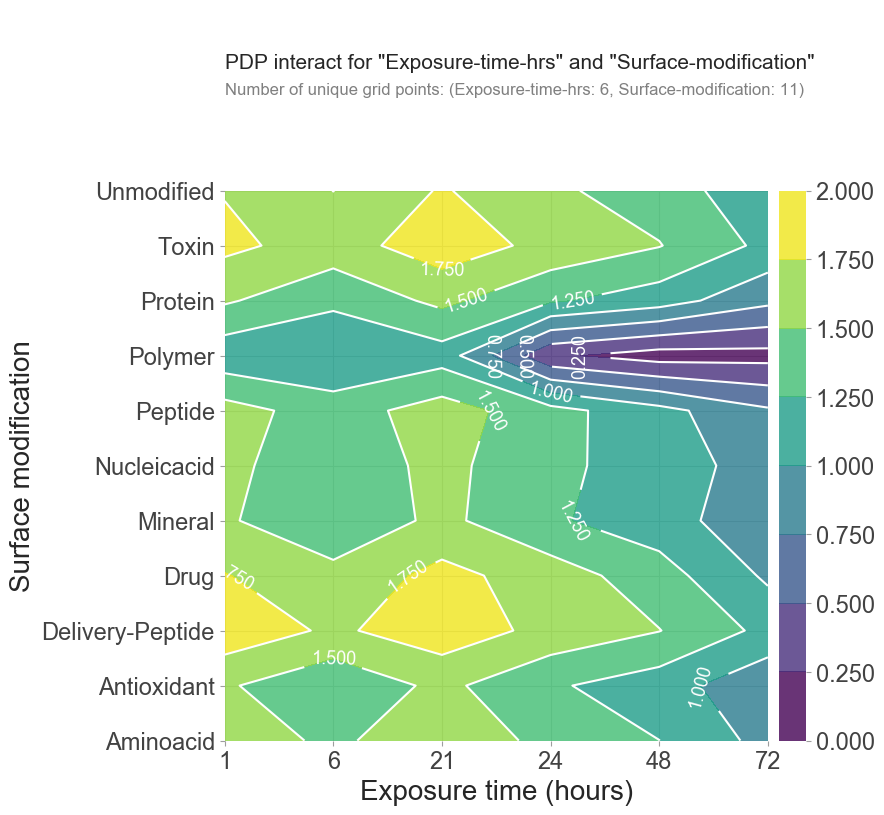

In [25]:
# 一个连续变量，一个分类变量

i=5
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

feature1 = "Exposure-time-hrs"
feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == feature1))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature1, feature_category.tolist()],percentile_ranges=[(3,97),(0,100)])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [feature1, OneHot_feature[i]], x_quantile=True, plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(feature1,OneHot_feature[i]),dpi=600,bbox_inches='tight') 

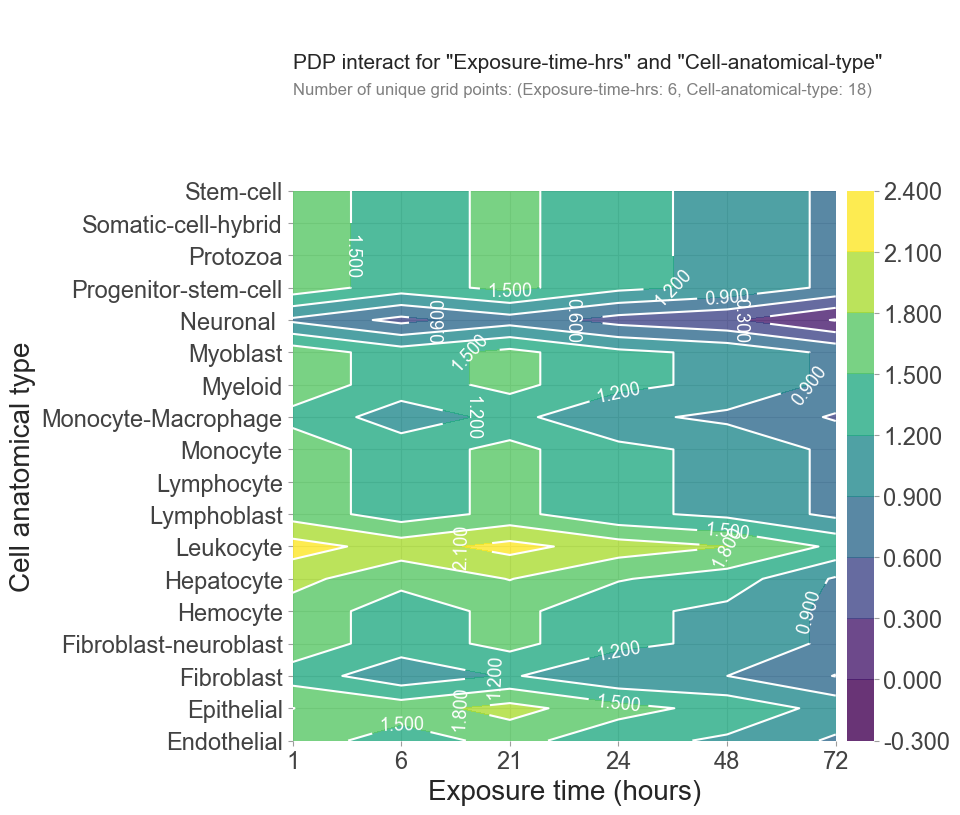

In [26]:
# 一个连续变量，一个分类变量

i=6
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

feature1 = "Exposure-time-hrs"
feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == feature1))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature1, feature_category.tolist()],percentile_ranges=[(3,97),(0,100)])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [feature1, OneHot_feature[i]], x_quantile=True, plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(feature1,OneHot_feature[i]),dpi=600,bbox_inches='tight') 

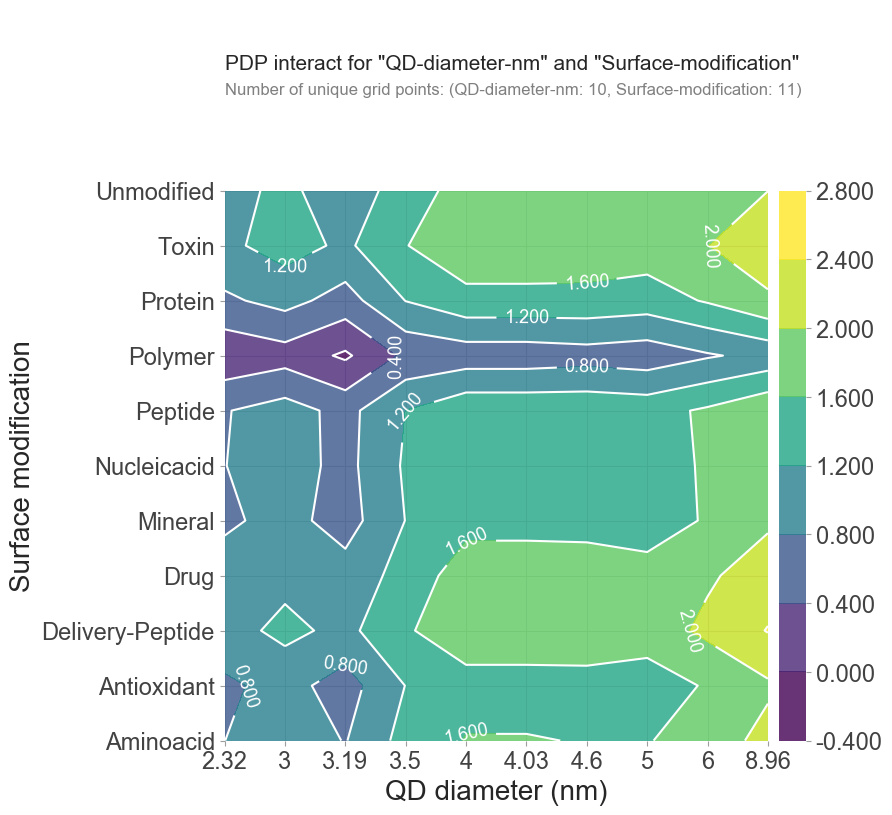

In [27]:
# 一个连续变量，一个分类变量

i=5
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

feature1 = "QD-diameter-nm"
feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == feature1))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature1, feature_category.tolist()],percentile_ranges=[(3,97),(0,100)])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [feature1, OneHot_feature[i]], x_quantile=True, plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(feature1,OneHot_feature[i]),dpi=600,bbox_inches='tight') 

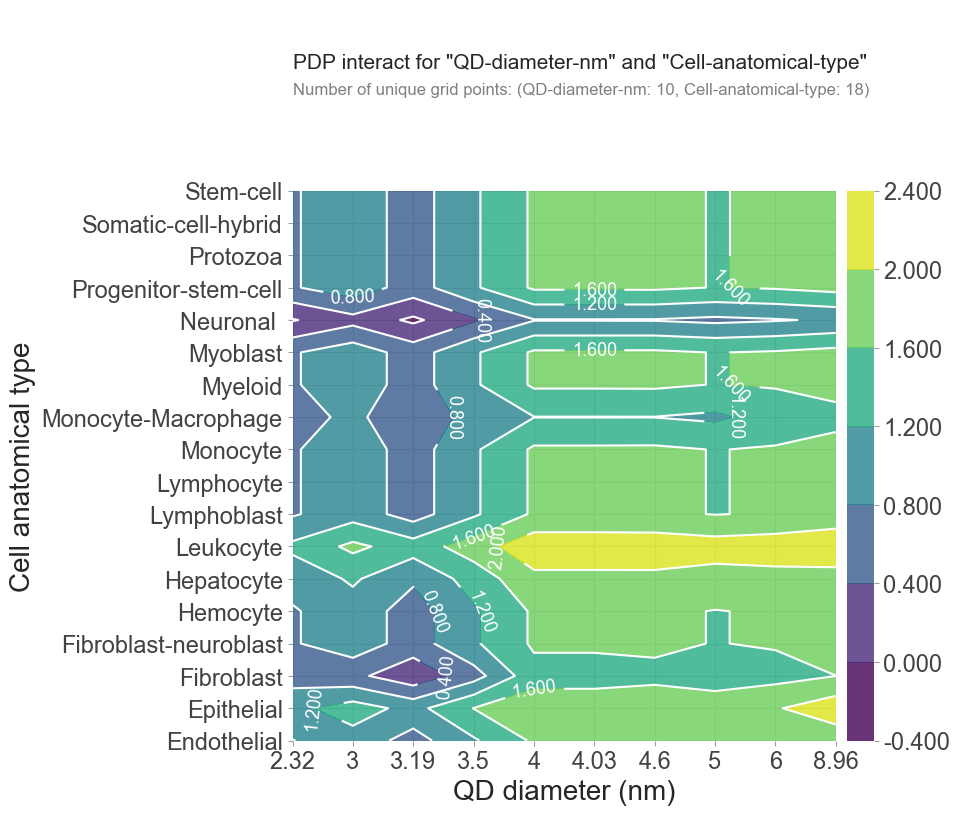

In [28]:
# 一个连续变量，一个分类变量

i=6
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

feature1 = "QD-diameter-nm"
feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == feature1))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature1, feature_category.tolist()],percentile_ranges=[(3,97),(0,100)])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [feature1, OneHot_feature[i]], x_quantile=True, plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(feature1,OneHot_feature[i]),dpi=600,bbox_inches='tight') 

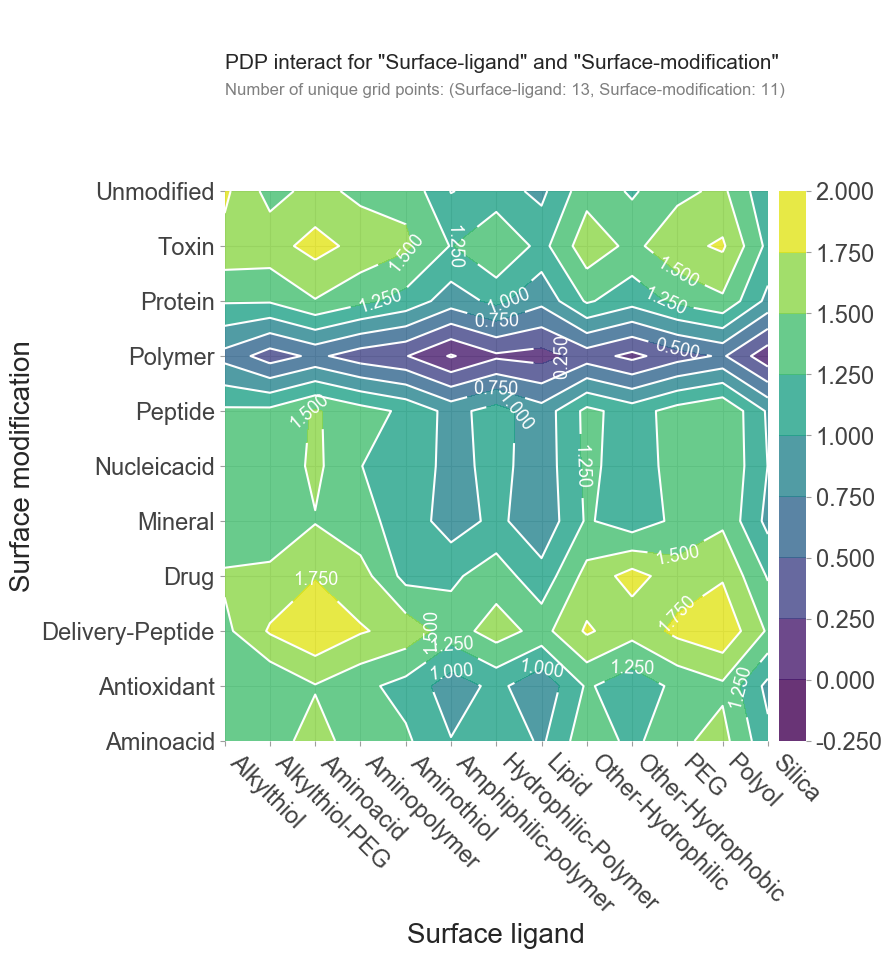

In [29]:
# 两个个分类变量

i=3
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category_1 = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

j=5
strat_ind=sum(OneHot_feature_num[0:j])+2
feature_category_2 = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[j]]

feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[j]))]
inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature_category_1.tolist(), feature_category_2.tolist()])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [OneHot_feature[i], OneHot_feature[j]], x_quantile=True, plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[j])
plot_feature_category = feature_category_2.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category_1.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_xticklabels(plot_feature_category,rotation=-45,ha ='left')
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(OneHot_feature[i],OneHot_feature[j]),dpi=600,bbox_inches='tight') 

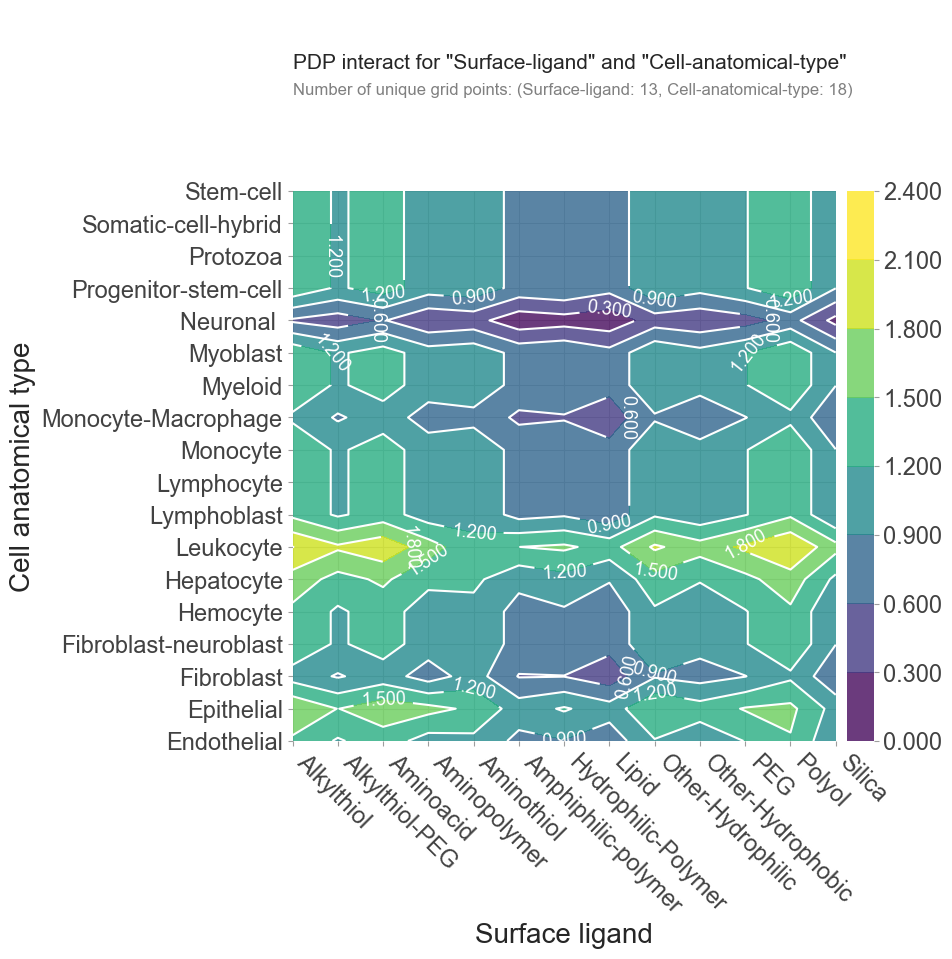

In [30]:
# 两个个分类变量

i=3
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category_1 = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

j=6
strat_ind=sum(OneHot_feature_num[0:j])+2
feature_category_2 = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[j]]

feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[j]))]

inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature_category_1.tolist(), feature_category_2.tolist()])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [OneHot_feature[i], OneHot_feature[j]], x_quantile=True, plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[j])
plot_feature_category = feature_category_2.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category_1.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_xticklabels(plot_feature_category,rotation=-45,ha ='left')
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(OneHot_feature[i],OneHot_feature[j]),dpi=600,bbox_inches='tight') 

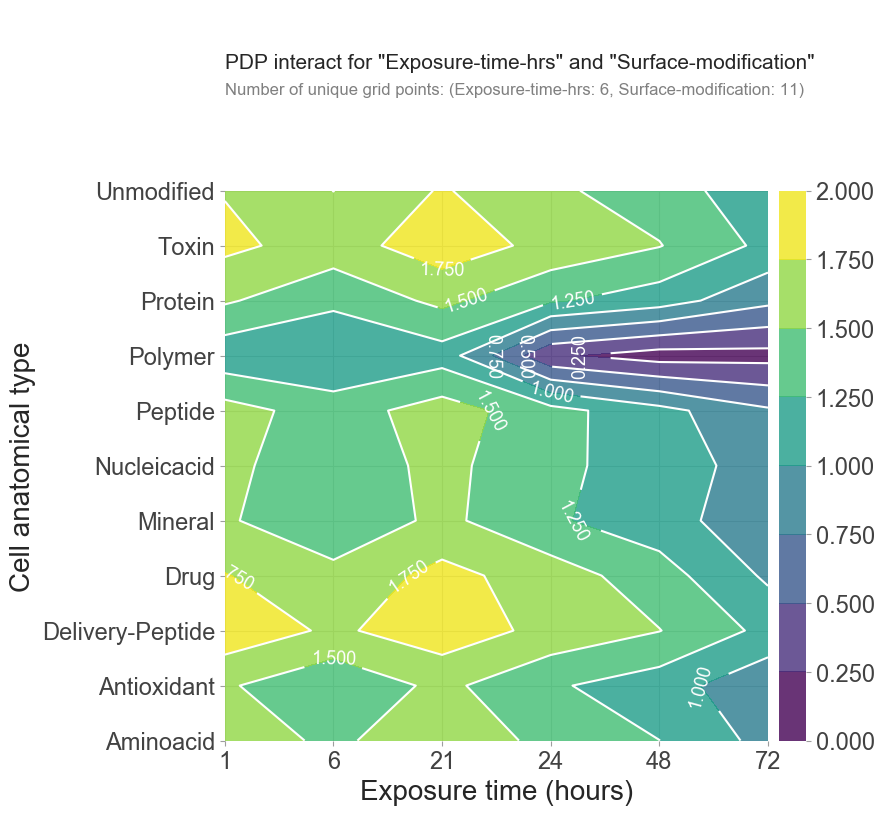

In [31]:
# 一个连续变量，一个分类变量

i=5
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

feature1 = "Exposure-time-hrs"
feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == feature1))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[j]))]
inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature1, feature_category.tolist()],percentile_ranges=[(3,97),(0,100)])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [feature1, OneHot_feature[i]], x_quantile=True, plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(feature1,OneHot_feature[i]),dpi=600,bbox_inches='tight') 

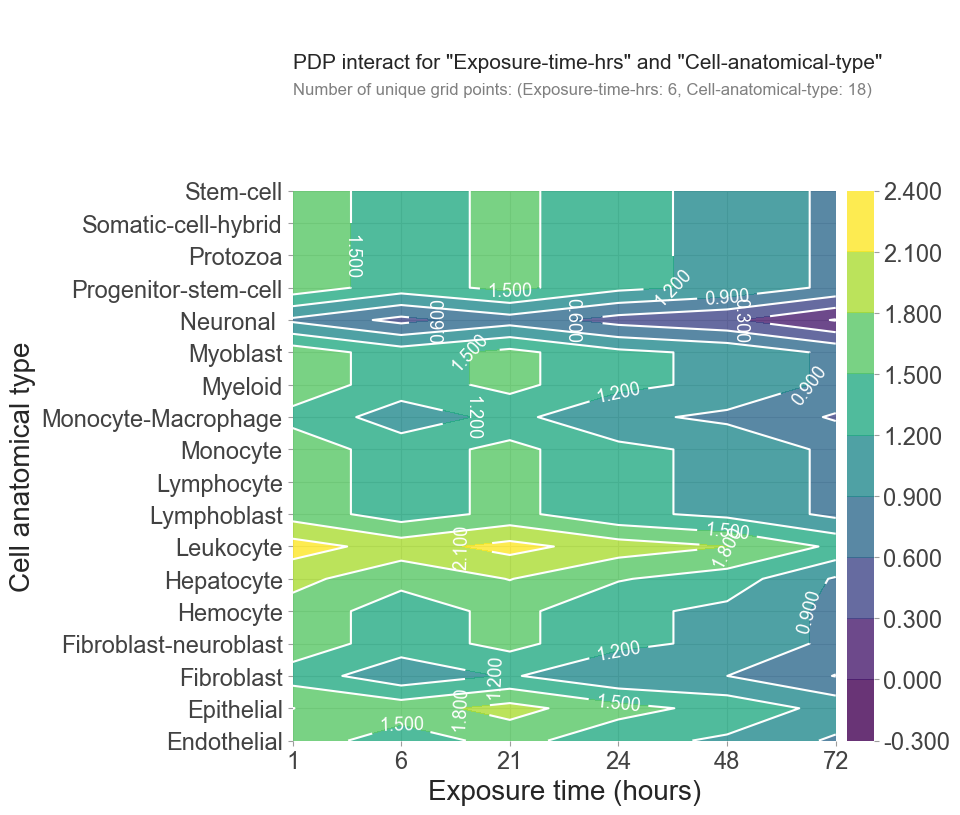

In [32]:
# 一个连续变量，一个分类变量

i=6
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

feature1 = "Exposure-time-hrs"
feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == feature1))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[j]))]

inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature1, feature_category.tolist()],percentile_ranges=[(3,97),(0,100)])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [feature1, OneHot_feature[i]], x_quantile=True, plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(feature1,OneHot_feature[i]),dpi=600,bbox_inches='tight') 

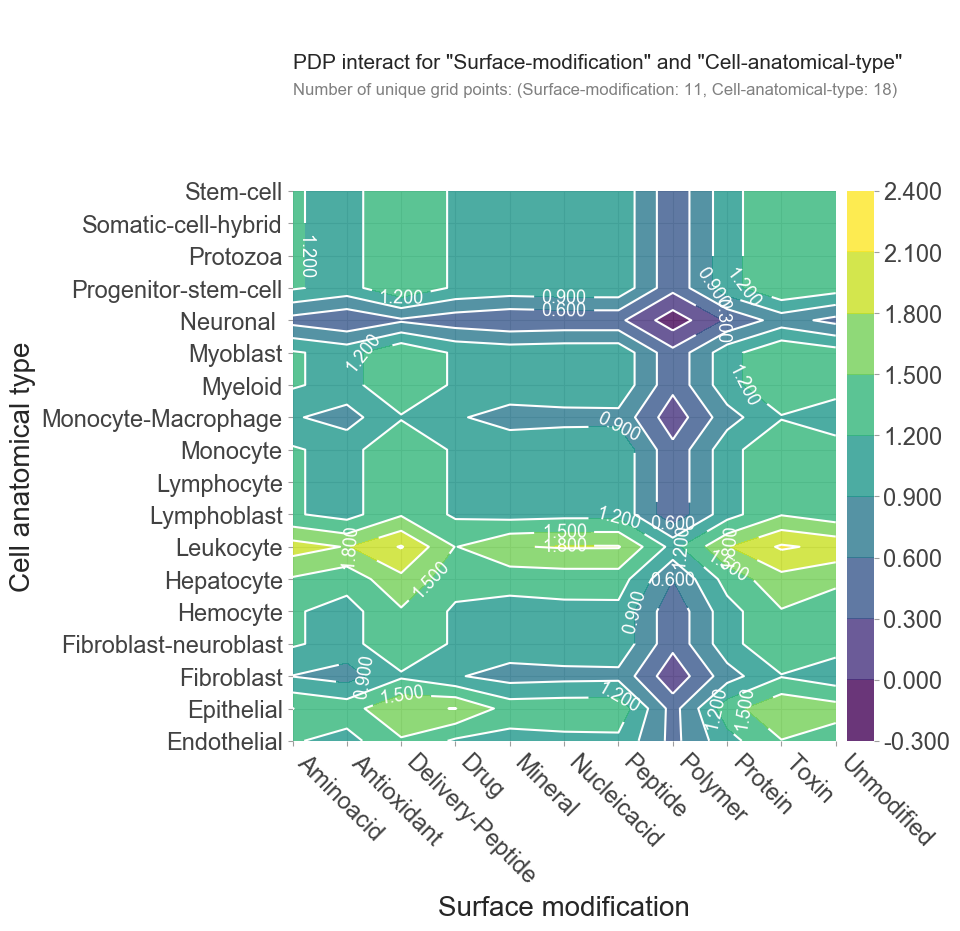

In [33]:
# 两个个分类变量

i=5
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category_1 = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]

j=6
strat_ind=sum(OneHot_feature_num[0:j])+2
feature_category_2 = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[j]]

feature_this_plot_1 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
feature_this_plot_2 = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[j]))]

inter_rf = pdp.pdp_interact(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    features=[feature_category_1.tolist(), feature_category_2.tolist()])

fig, axes = pdp.pdp_interact_plot(
    inter_rf, [OneHot_feature[i], OneHot_feature[j]], x_quantile=True, plot_type='contour', plot_pdp=False)

len_feature_name = len(OneHot_feature[j])
plot_feature_category = feature_category_2.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_yticklabels(plot_feature_category)

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category_1.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

axes['pdp_inter_ax'].set_xticklabels(plot_feature_category,rotation=-45,ha ='left')
axes['pdp_inter_ax'].set_xlabel(feature_this_plot_1, fontsize=20)
axes['pdp_inter_ax'].set_ylabel(feature_this_plot_2, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Global_PDP_two_%s_%s.jpg"%(OneHot_feature[i],OneHot_feature[j]),dpi=600,bbox_inches='tight') 

## 3.2 Loca feature contributions

In [34]:
feature_this_plot = []
for item in sorted_features:
    itemindex = np.argwhere(fature_name == item)
    feature_this_plot.append(feature_plot_name[int(itemindex)])

#### 3.2.1 Numeric feature

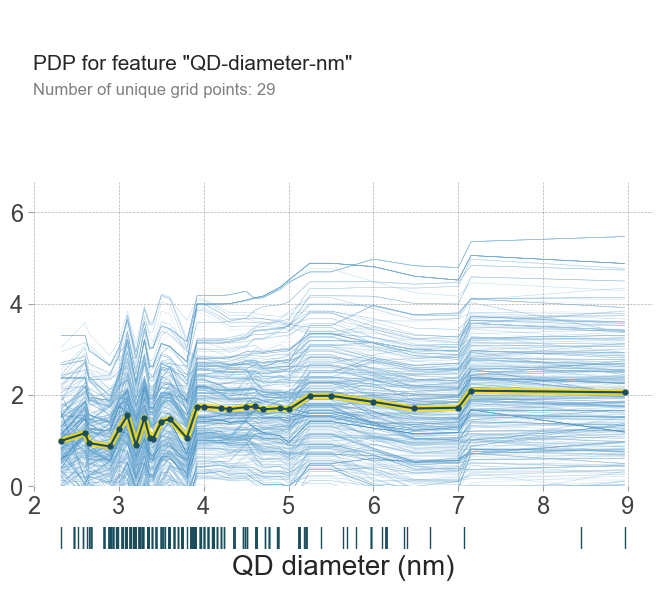

In [35]:
feature = "QD-diameter-nm"
feature_this_plot = feature_plot_name[int(np.argwhere(fature_name == feature))]

pdp_NP_none_M = pdp.pdp_isolate(model=Model,
                        dataset=select_X,
                        model_features=select_X.columns,
                        feature=feature,
                        percentile_range=(3, 97),
                        n_jobs=-1, num_grid_points=50)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=True, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=False,
                    feature_name=feature,
                    figsize=(8, 7))
axes['pdp_ax']['_count_ax'].set_xlabel(feature_this_plot, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Local_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

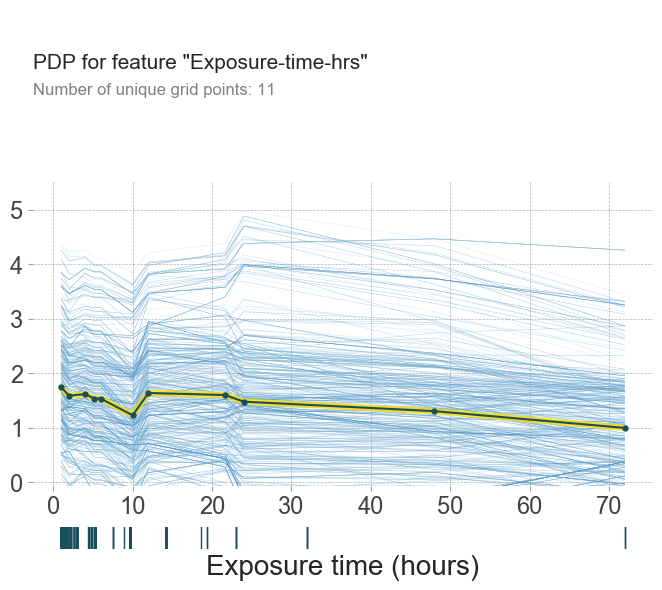

In [36]:
feature = "Exposure-time-hrs"
feature_this_plot = feature_plot_name[int(np.argwhere(fature_name == feature))]

pdp_NP_none_M = pdp.pdp_isolate(model=Model,
                        dataset=select_X,
                        model_features=select_X.columns,
                        feature=feature,
                        percentile_range=(3, 97),
                        n_jobs=-1, num_grid_points=50)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_NP_none_M, 
                    plot_lines=True, center=False, 
                    plot_pts_dist=True, 
                    x_quantile=False,
                    feature_name=feature,
                    figsize=(8, 7))
axes['pdp_ax']['_count_ax'].set_xlabel(feature_this_plot, fontsize=20)
fig.savefig("./Result_fig_IC50_LightGBM/Local_PDP_%s.jpg"%feature,dpi=600,bbox_inches='tight') 

#### 3.1.1.2 One-hot encoding feature

In [37]:
OneHot_feature = ['QD-source','Core','Shell','Surface-ligand','Surface-charge','Surface-modification',
                    'Cell-anatomical-type','Cell-source-species','Cell-origin','Assay-type','Delivery-type']
OneHot_feature_num = [2,6,9,13,4,11,18,13,2,18,2]
plt.rcParams['font.size'] ='8'

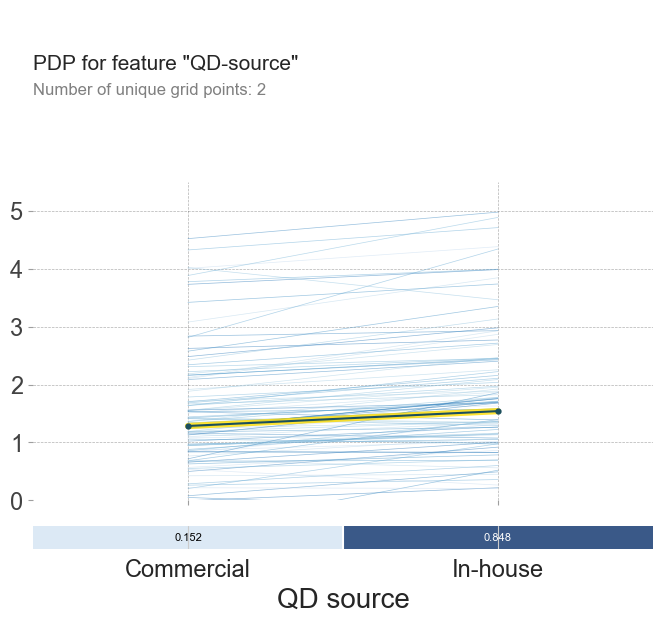

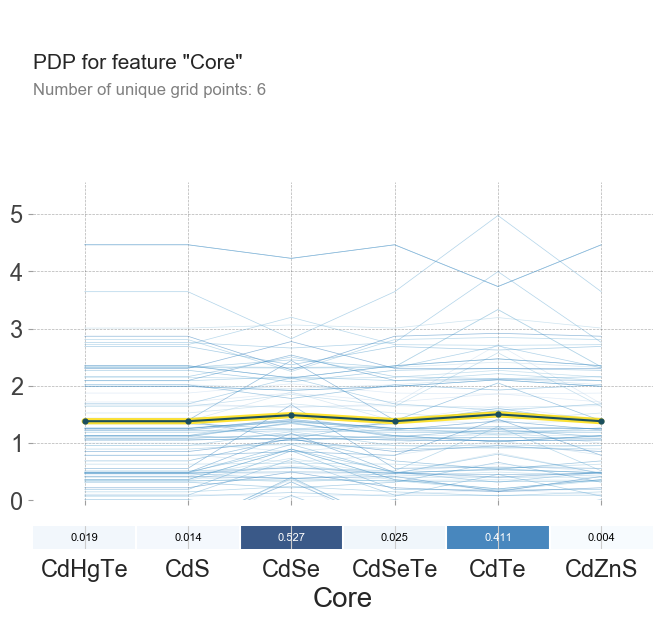

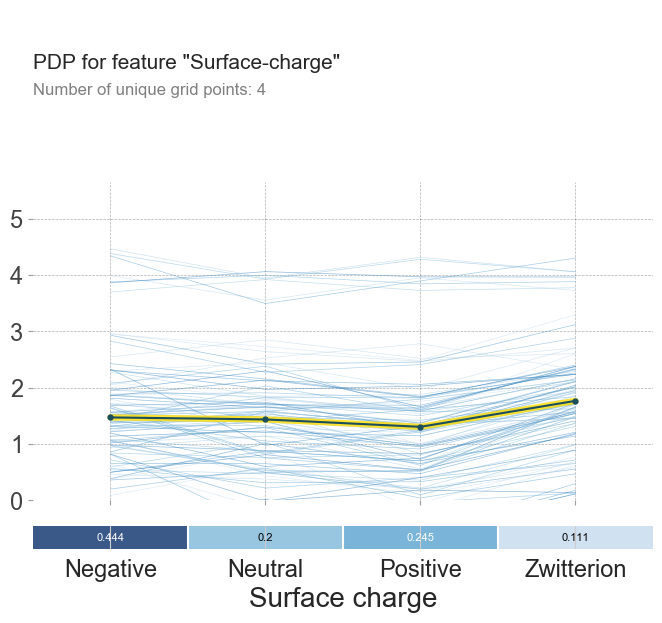

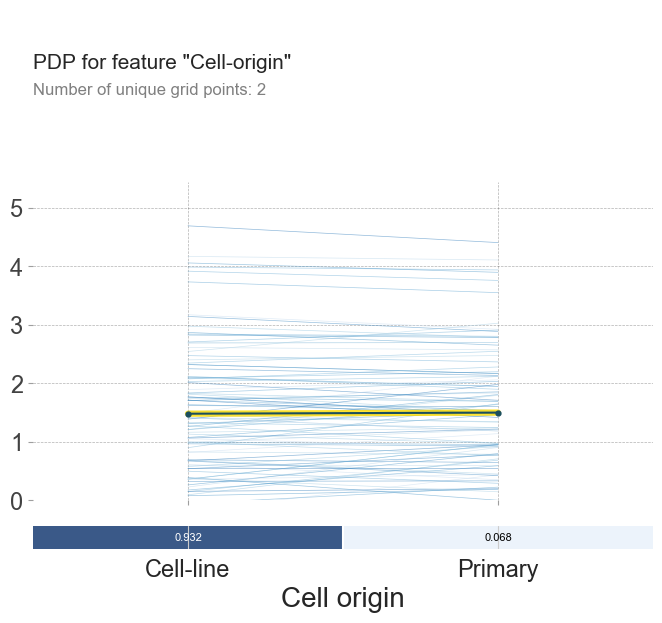

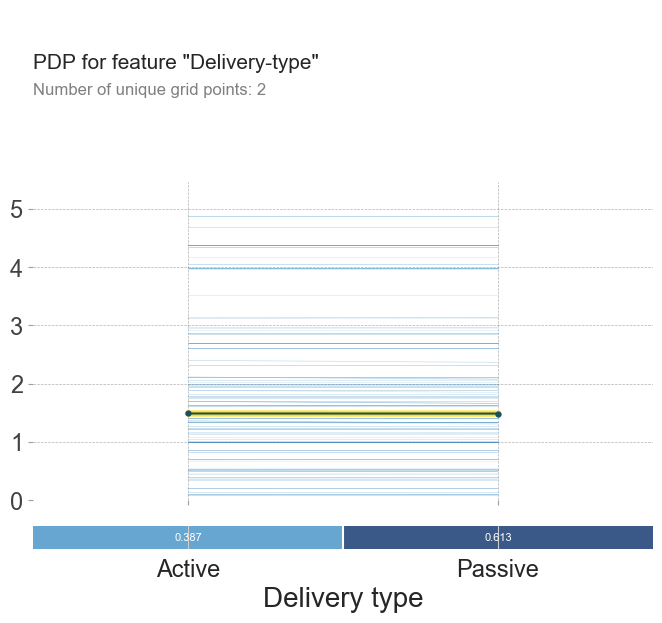

In [38]:
for i in [0,1,4,8,10]:
    strat_ind=sum(OneHot_feature_num[0:i])+2
    
    feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]
    feature_this_plot = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
    
    pdp_StoreType = pdp.pdp_isolate(
        model=Model, dataset=select_X, model_features=select_X.columns, 
        feature=feature_category.tolist())
    fig, axes = pdp.pdp_plot(pdp_StoreType, feature_name=OneHot_feature[i], plot_lines=True, frac_to_plot=100, 
                             plot_pts_dist=True,center=False,figsize=(8, 7))
    
    len_feature_name = len(OneHot_feature[i])
    plot_feature_category = feature_category.tolist()
    for item in range(len(plot_feature_category )):
        plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]

    axes['pdp_ax']['_count_ax'].set_xticklabels(plot_feature_category,rotation=0, fontsize=17)
    axes['pdp_ax']['_count_ax'].set_xlabel(feature_this_plot, fontsize=20)
    fig.savefig("./Result_fig_IC50_LightGBM/Local_ICE_%s.jpg"%OneHot_feature[i],dpi=600,bbox_inches='tight')

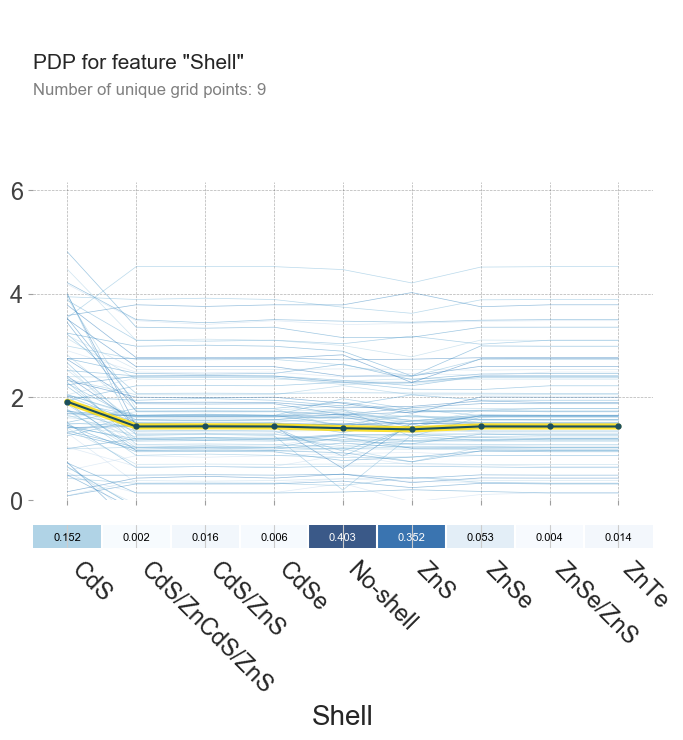

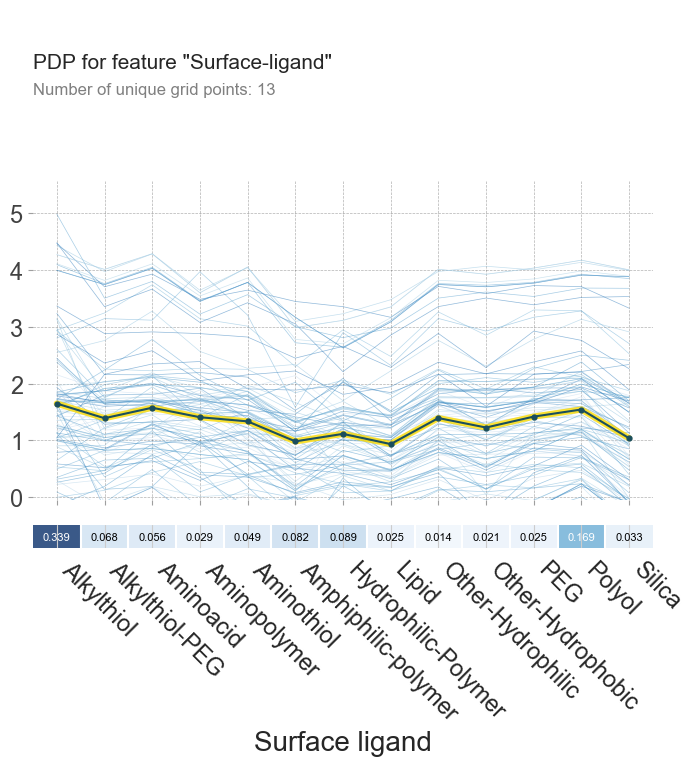

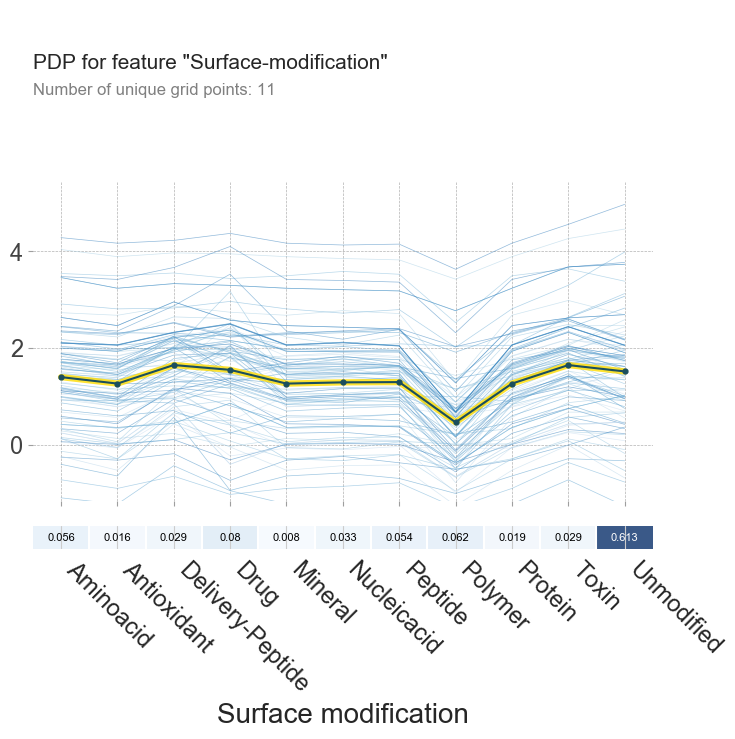

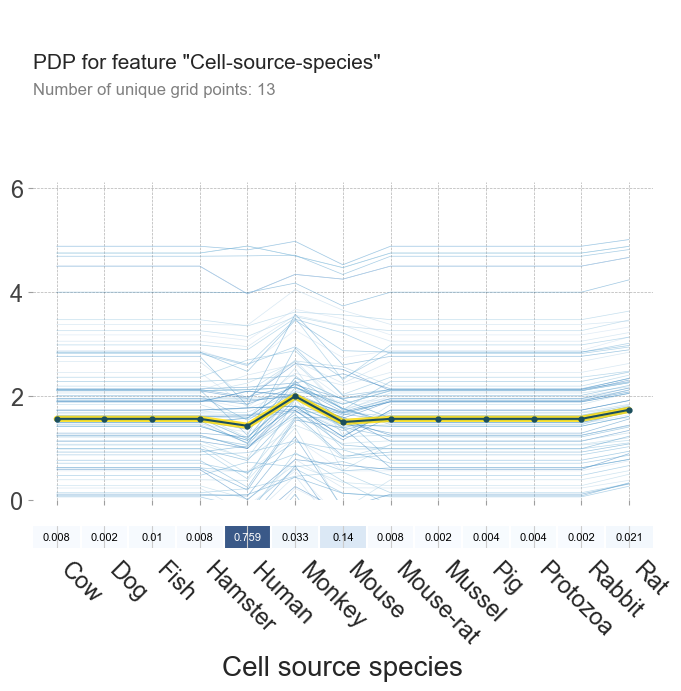

In [39]:
for i in [2,3,5,7]:
    strat_ind=sum(OneHot_feature_num[0:i])+2
    feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]
    feature_this_plot = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]
    
    pdp_StoreType = pdp.pdp_isolate(
        model=Model, dataset=select_X, model_features=select_X.columns, 
        feature=feature_category.tolist() ,xticks=plot_feature_category
    )
    fig, axes = pdp.pdp_plot(pdp_StoreType, feature_name=OneHot_feature[i], plot_lines=True, frac_to_plot=100, 
                             plot_pts_dist=True,center=False,figsize=(8, 7))

    len_feature_name = len(OneHot_feature[i])
    plot_feature_category = feature_category.tolist()
    for item in range(len(plot_feature_category )):
        plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]
    
    axes['pdp_ax']['_count_ax'].set_xticklabels(plot_feature_category,ha ='left',rotation=-45, fontsize=17)
    axes['pdp_ax']['_count_ax'].set_xlabel(feature_this_plot, fontsize=20)
    fig.savefig("./Result_fig_IC50_LightGBM/Local_ICE_%s.jpg"%OneHot_feature[i],dpi=600,bbox_inches='tight')  

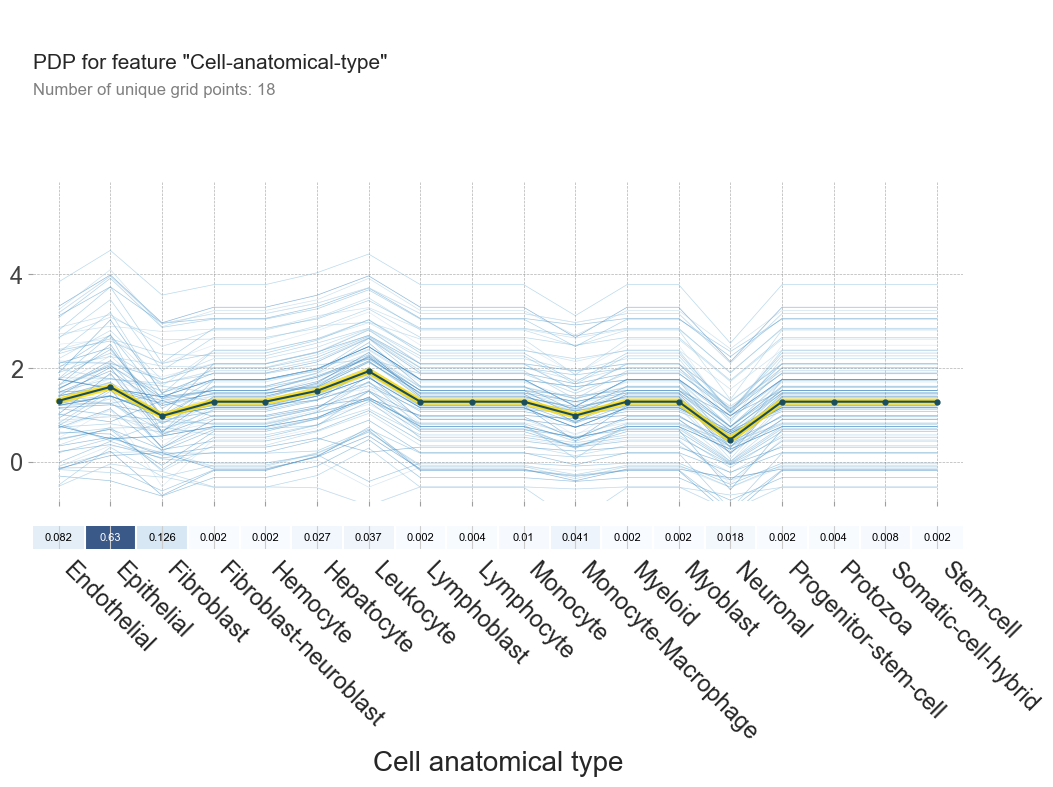

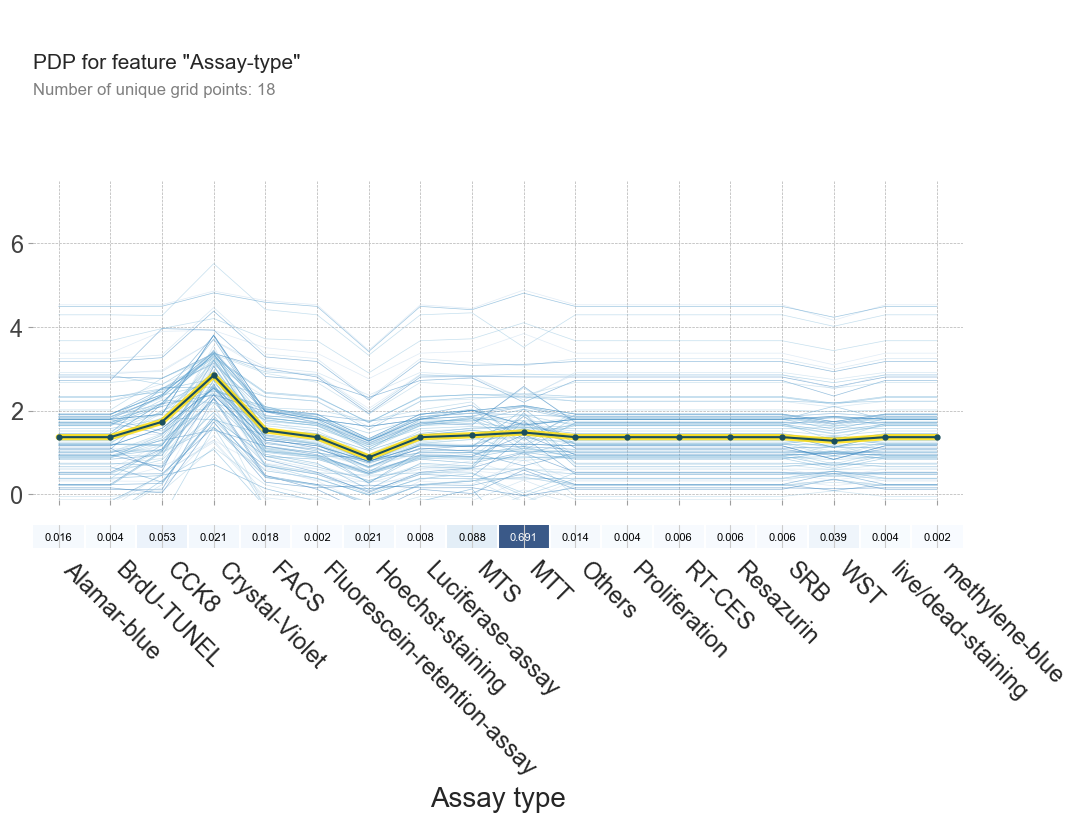

In [40]:
for i in [6,9]:
    strat_ind=sum(OneHot_feature_num[0:i])+2
    feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]
    feature_this_plot = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]

    pdp_StoreType = pdp.pdp_isolate(
        model=Model, dataset=select_X, model_features=select_X.columns, 
        feature=feature_category.tolist() ,xticks=plot_feature_category
    )
    fig, axes = pdp.pdp_plot(pdp_StoreType, feature_name=OneHot_feature[i], plot_lines=True, frac_to_plot=100, 
                             plot_pts_dist=True,center=False,figsize=(12, 7))

    len_feature_name = len(OneHot_feature[i])
    plot_feature_category = feature_category.tolist()
    for item in range(len(plot_feature_category )):
        plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]
    
    axes['pdp_ax']['_count_ax'].set_xticklabels(plot_feature_category,ha ='left',rotation=-45, fontsize=17)
    axes['pdp_ax']['_count_ax'].set_xlabel(feature_this_plot, fontsize=20)
    fig.savefig("./Result_fig_IC50_LightGBM/Local_ICE_%s.jpg"%OneHot_feature[i],dpi=600,bbox_inches='tight')   

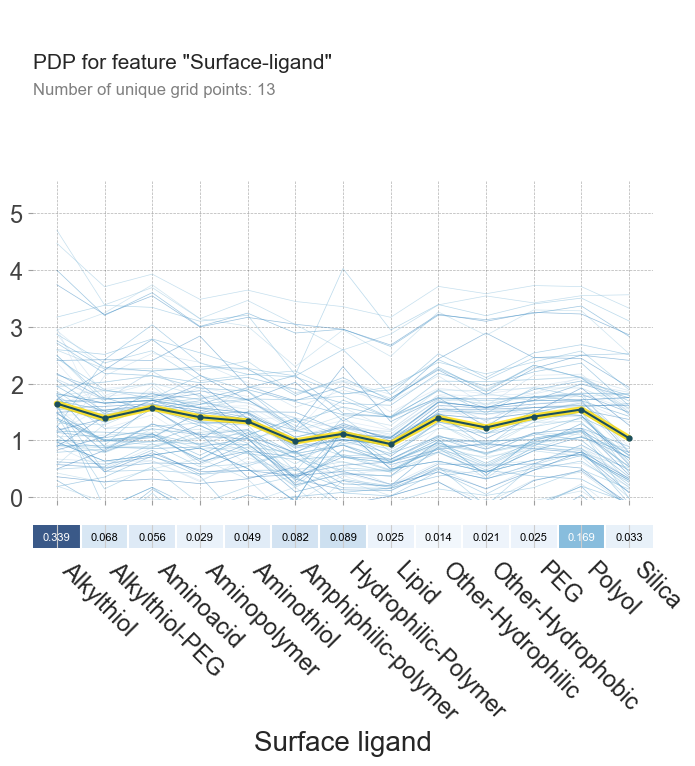

In [41]:
i=3
strat_ind=sum(OneHot_feature_num[0:i])+2
feature_category = select_X.columns[strat_ind:strat_ind+OneHot_feature_num[i]]
feature_this_plot = feature_plot_name[int(np.argwhere(fature_name == OneHot_feature[i]))]

pdp_StoreType = pdp.pdp_isolate(
    model=Model, dataset=select_X, model_features=select_X.columns, 
    feature=feature_category.tolist() ,xticks=plot_feature_category
)
fig, axes = pdp.pdp_plot(pdp_StoreType, feature_name=OneHot_feature[i], plot_lines=True, frac_to_plot=100, 
                             plot_pts_dist=True,center=False,figsize=(8, 7))

len_feature_name = len(OneHot_feature[i])
plot_feature_category = feature_category.tolist()
for item in range(len(plot_feature_category )):
    plot_feature_category[item] = plot_feature_category[item][len_feature_name+1:]
    
axes['pdp_ax']['_count_ax'].set_xticklabels(plot_feature_category,ha ='left',rotation=-45, fontsize=17)
axes['pdp_ax']['_count_ax'].set_xlabel(feature_this_plot, fontsize=20)   
fig.savefig("./Result_fig_IC50_LightGBM/Local_ICE_%s.jpg"%OneHot_feature[i],dpi=600,bbox_inches='tight')